<center>
    <span style="font-size: 1.0em; color:black">
        <b>Last update:</b> September 2022
    </span>
    <br><br>
    <span style="font-size: 2.5em; color:black"><b>
        FLOWPanel
    </b></span>
    <br>
    <span style="font-size: 0.95em;"><i>
        Theory, implementation, examples, and validation
    </i></span> 
</center>

In [1]:
using Revise

using FLOWPanel
pnl = FLOWPanel
gt  = FLOWPanel.GeometricTools


import ForwardDiff as FD
import LaTeXStrings: @L_str
import PyPlot as plt
plt.using3D()

plt.rc("font", family="Times New Roman")            # Text font
plt.rc("mathtext", fontset="stix")                  # Math font

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
ANNOT_SIZE = 10


data_path = pnl.def_data_path         # Data path
                                      # Airfoil data path
airfoil_path = joinpath(data_path, "airfoils");

macro javascript_str(s) display("text/javascript", s); end
javascript"""
MathJax.Extension["TeX/cancel"]={version:"2.4.0",ALLOWED:{color:1,mathcolor:1,background:1,mathbackground:1,padding:1,thickness:1}};MathJax.Hub.Register.StartupHook("TeX Jax Ready",function(){var c=MathJax.InputJax.TeX,a=MathJax.ElementJax.mml,b=MathJax.Extension["TeX/cancel"];b.setAttributes=function(h,e){if(e!==""){e=e.replace(/ /g,"").split(/,/);for(var g=0,d=e.length;g<d;g++){var f=e[g].split(/[:=]/);if(b.ALLOWED[f[0]]){if(f[1]==="true"){f[1]=true}if(f[1]==="false"){f[1]=false}h[f[0]]=f[1]}}}return h};c.Definitions.Add({macros:{cancel:["Cancel",a.NOTATION.UPDIAGONALSTRIKE],bcancel:["Cancel",a.NOTATION.DOWNDIAGONALSTRIKE],xcancel:["Cancel",a.NOTATION.UPDIAGONALSTRIKE+" "+a.NOTATION.DOWNDIAGONALSTRIKE],cancelto:"CancelTo"}},null,true);c.Parse.Augment({Cancel:function(e,g){var d=this.GetBrackets(e,""),f=this.ParseArg(e);var h=b.setAttributes({notation:g},d);this.Push(a.menclose(f).With(h))},CancelTo:function(e,g){var i=this.ParseArg(e),d=this.GetBrackets(e,""),f=this.ParseArg(e);var h=b.setAttributes({notation:a.NOTATION.UPDIAGONALSTRIKE+" "+a.NOTATION.UPDIAGONALARROW},d);i=a.mpadded(i).With({depth:"-.1em",height:"+.1em",voffset:".1em"});this.Push(a.msup(a.menclose(f).With(h),i))}});MathJax.Hub.Startup.signal.Post("TeX cancel Ready")});MathJax.Ajax.loadComplete("[MathJax]/extensions/TeX/cancel.js");
"""

# Table of Contents

In [2]:
macro javascript_str(s) display("text/javascript", s); end

javascript"""
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
"""

# Potential Flow &mdash; Problem Formulation

(This section is a summary of Katz and Plotkin's *Low Speed Aerodynamics*, Sec 3.2)

By [Helmholtz' decomposition theorem](https://en.wikipedia.org/wiki/Helmholtz_decomposition), any velocity field $\mathbf{u}$ can be decomposed into a uniform component, an irrotational component, and a solenoidal component as

\begin{align*}
        \mathbf{u} 
    = 
        \underbrace{\mathbf{u}_\infty}_\text{uniform} 
        + \underbrace{\nabla\phi}_\text{irrotational} 
        + \underbrace{\nabla\times\boldsymbol{\psi}}_\text{solenoidal} 
,\end{align*}

where $\mathbf{u}_\infty(t)$ is the freestream, $\phi (\mathbf{x}, t)$ is a scalar-potential field, and $\boldsymbol\psi (\mathbf{x}, t)$ is a vector-potential field.

>**NOTE:** Even though here we show $\mathbf{u}_\infty$ as its own component, the freestream can be rolled into the potential field as a linearly-varying potential, giving a uniform velocity field.

Assuming incompressible flow, the continuity equation poses a Laplace equation for the scalar-potential as

\begin{align*}
        \nabla \cdot \mathbf{u} = 0
    \quad\Rightarrow\quad
        \nabla^2 \phi = 0
.\end{align*}

Before we continue, let us derive a useful integral identity: [Green's second identity](https://en.wikipedia.org/wiki/Green%27s_identities).
Let $f$ and $g$ be two differentiable functions, we have

\begin{align*}
    \nabla \cdot \left( f \nabla g - g \nabla f \right) = f \nabla^2 g - g \nabla^2 f
.\end{align*}

The divergence theorem then leads to

\begin{align*}
        \int\limits_{\partial V} 
            \left( f \nabla g - g \nabla f \right) \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
    & =
        \int\limits_{V} 
            \left( f \nabla^2 g - g \nabla^2 f \right)
        \,\mathrm{d}V
,\end{align*}
over any volume $V$. Here we have defined the normal $\hat{\mathbf{n}}$  as pointing outward from $V$.

Using Green's second identity, we now define $f(\mathbf{x}) \equiv \frac{1}{\Vert \mathbf{x} - \mathbf{x}_p \Vert^2} = \frac{1}{r}$ and $g(\mathbf{x}) \equiv \phi(\mathbf{x})$ where $r$ is the distance to a point $\mathbf{x}_p$ defining an arbitrary fixed center, and the identity gives

\begin{align*}
        \int\limits_{\partial V} 
            \left[ \frac{1}{r} \nabla \phi - \phi \nabla \left(\frac{1}{r}\right) \right] \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
    & =
        \int\limits_{V} 
            \left[ \frac{1}{r} \cancelto{0}{\nabla^2 \phi} - \phi \cancelto{0}{\nabla^2 \left(\frac{1}{r}\right)} \right]
        \,\mathrm{d}V
\end{align*}

\begin{align*}
    \Rightarrow \boxed{
        \int\limits_{\partial V} 
            \left[ \frac{1}{r} \nabla \phi - \phi\nabla \left(\frac{1}{r}\right) \right] \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
    = %
        0
    }
.\end{align*}

The integrand becomes singular when evaluated at $\mathbf{x}_p$ since $\lim \limits_{r\rightarrow 0 }\frac{1}{r} = \infty$, which we will use to obtain some expressions depending on whether $\mathbf{x}_p$ lays inside, outside, or at the boundary of $V$.

In the case that $\mathbf{x}_p \cancel{\in} V$, the integral equation is automatically satisfied. In the case that $\mathbf{x}_p \in V$, we introduce a hole in $V$ in the form of a sphere of radius $\epsilon$ surrounding $\mathbf{x}_p$, and the integral equation is then automatically satisfied over the domain $V \backslash V_\epsilon$:

\begin{align*}
    &
        \int\limits_{\partial (V \backslash V_\epsilon)} 
            \left[ \frac{1}{r} \nabla \phi - \phi\nabla \left(\frac{1}{r}\right) \right] \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
    = %
        0
    \\
    \Leftrightarrow &
        \int\limits_{\partial V} 
            \left[ \frac{1}{r} \nabla \phi - \phi\nabla \left(\frac{1}{r}\right) \right] \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
        -
        \int\limits_{\partial V_\epsilon} 
            \left[ \frac{1}{r} \nabla \phi - \phi\nabla \left(\frac{1}{r}\right) \right] \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
    = %
        0
.\end{align*}


Since $r$ is centered at $\mathbf{x}_p$ and the normal $\hat{\mathbf{n}}$ points radially inwards the sphere (since all normals point outside of the volume $V$), the second integral becomes


\begin{align*}
        \int\limits_{\partial V_\epsilon} 
            \left[ \frac{1}{r} \nabla \phi - \phi\nabla \left(\frac{1}{r}\right) \right] \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
    = %
        - \int\limits_{\partial V_\epsilon} 
            \left( \frac{1}{r} \frac{\partial \phi}{\partial r} + \frac{\phi}{r^2} \right) 
        \,\mathrm{d}S
.\end{align*}

In the limit that $\epsilon$ is infinitesimally small, the integral can be approximated as 

\begin{align*}
        \int\limits_{\partial V_\epsilon} 
            \left( \frac{1}{r} \frac{\partial \phi}{\partial r} - \frac{\phi}{r^2} \right) 
        \,\mathrm{d}S
    \approx
        - \left(
            \frac{\partial \phi}{\partial r}(\mathbf{x}_p) \lim\limits_{r\rightarrow 0} \frac{1}{r}
            + 
            \phi (\mathbf{x}_p) \lim\limits_{r\rightarrow 0} \frac{1}{r^2} 
        \right)
        \lim\limits_{\epsilon\rightarrow 0} 4 \pi \epsilon^2
,\end{align*}
where $4 \pi \epsilon^2$ is the surface area of the sphere.

Assuming $\phi(\mathbf{x}_p) \neq \pm\infty$ and $\frac{\partial \phi}{\partial r}(\mathbf{x}_p) \neq \pm\infty$, we have

\begin{align*}
        \int\limits_{\partial V_\epsilon} 
            \left( \frac{1}{r} \frac{\partial \phi}{\partial r} - \frac{\phi}{r^2} \right) 
        \,\mathrm{d}S
    & \approx
            - 4 \pi \frac{\partial \phi}{\partial r}(\mathbf{x}_p) \cancelto{0}{\lim\limits_{\rho\rightarrow 0} \frac{\rho ^2}{\rho}}
            - 
            4 \pi \phi(\mathbf{x}_p) \cancelto{1}{\lim\limits_{\rho\rightarrow 0} \frac{\rho^2}{\rho^2}}
.\end{align*}
Thus,

\begin{align*}
        \int\limits_{\partial V_\epsilon} 
            \left[ \frac{1}{r} \nabla \phi - \phi\nabla \left(\frac{1}{r}\right) \right] \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
    & =
        4 \pi \phi(\mathbf{x}_p)
.\end{align*}

Substituting this back into the original equation,

\begin{align*}
        \int\limits_{\partial V} 
            \left[ \frac{1}{r} \nabla \phi - \phi\nabla \left(\frac{1}{r}\right) \right] \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
        -
        4 \pi \phi(\mathbf{x}_p)
    = %
        0
,\end{align*}
and since $\mathbf{x}_p$ is any arbitrary point inside $V$, we conclude

\begin{align*}
    \boxed{
        \phi(\mathbf{x})
    = %
        \frac{1}{4 \pi }
        \int\limits_{\partial V} 
            \left[ \frac{1}{r} \nabla \phi - \phi\nabla \left(\frac{1}{r}\right) \right] \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
    }
    , \quad \forall \mathbf{x} \in V
.\end{align*}

If $\mathbf{x}_p$ lays in the boundary of $V$ (*i.e.*, $\mathbf{x}_p \in \partial V$), we repeat the same derivation except that only half of the sphere $V_\epsilon$ is contained in the integration domain, and we conclude

\begin{align*}
    \boxed{
        \phi(\mathbf{x})
    = %
        \frac{1}{2 \pi }
        \int\limits_{\partial V} 
            \left[ \frac{1}{r} \nabla \phi - \phi\nabla \left(\frac{1}{r}\right) \right] \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
    }
    , \quad \forall \mathbf{x} \in \partial V
.\end{align*}


We merge the two equations to get


\begin{align*}
    \therefore
    \boxed{
        \phi(\mathbf{x})
    = %
        \frac{f_{\tiny \partial V}(\mathbf{x})}{\pi }
        \int\limits_{\partial V} 
            \left[ \frac{1}{r} \nabla \phi - \phi\nabla \left(\frac{1}{r}\right) \right] \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
    }
    , \quad \forall \mathbf{x} \in V
    , \quad \text{where } 
    f_{\tiny \partial V}(\mathbf{x}) = \begin{cases}
                                          1/4  & \mathbf{x} \in V \backslash \partial V \\
                                          1/2  & \mathbf{x} \in \partial V
                                        \end{cases}
.\end{align*}

Now, consider the case that $V$ is infinitely large in all directions (with bound $\partial V_\infty$) while also having a hole (bound $\partial V_b$, which represents a solid body immersed in the domain), leading to $\partial V = \partial V_b \cup \partial V_\infty$. 
In $V$, the potential is calculated as 

\begin{align*}
        \phi(\mathbf{x})
    = %
        \frac{f_{\tiny \partial V_b}(\mathbf{x})}{\pi }
        \int\limits_{\partial V_b} 
            \left[ \frac{1}{r} \nabla \phi - \phi\nabla \left(\frac{1}{r}\right) \right] \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
        +
        \underbrace{
            \frac{1}{4\pi }
            \int\limits_{\partial V_\infty} 
                \left[ \frac{1}{r} \nabla \phi - \phi\nabla \left(\frac{1}{r}\right) \right] \cdot \hat{\mathbf{n}} 
            \,\mathrm{d}S
        }_{
        \equiv \phi_\infty(\mathbf{x})
        }
.\end{align*}

When the isolated body is considered as a volume of its own, $V_b$, we can define an internal potential (*i.e.*, internal to the body) as $\phi_i$. When $\mathbf{x}_p$ is defined as being outside of $V_b$ (but still inside $V$), we have


\begin{align*}
        \frac{f_{\tiny \partial V_b}(\mathbf{x})}{\pi }
        \int\limits_{\partial V_b} 
            \left[ \frac{1}{r} \nabla \phi_i - \phi_i\nabla \left(\frac{1}{r}\right) \right] \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
    = %
        0
,\end{align*}

from the Laplace equation.

Since the superposition of two solutions to the Laplace equation yields another valid solution, we can add this internal potential to the previous equation to obtain

\begin{align*}
        \phi(\mathbf{x})
    = %
        \frac{f_{\tiny \partial V_b}(\mathbf{x})}{\pi }
        \int\limits_{\partial V_b} 
            \left[ 
                \frac{1}{r} \nabla \left(\phi - \phi_i\right)
                - 
                \left(\phi - \phi_i\right) \nabla \left(\frac{1}{r}\right) 
            \right] \cdot \hat{\mathbf{n}} 
        \,\mathrm{d}S
        +
        \phi_\infty(\mathbf{x})
,\end{align*}

where the negative sign accompanying $\phi_i$ comes from always requiring $\hat{\mathbf{n}}$ to point outward from $V$.

This equation poses a boundary integral equation (BIE), with the potential $\phi$ being fully determined by its value at the boundaries. We can then define

\begin{align*}
    &
    \boxed{-\sigma \equiv \frac{\partial \phi}{\partial n} - \frac{\partial \phi_i}{\partial n}}
    \\ &
    \boxed{-\mu \equiv \phi - \phi_i}
\end{align*}

resulting in the following BIE,

\begin{align*}
    \boxed{
            \phi(\mathbf{x})
        = %
            -\frac{f_{\tiny \partial V_b}(\mathbf{x})}{\pi }
            \int\limits_{\partial V_b} 
                \left[ 
                    \sigma \frac{1}{r}
                    - 
                    \mu \hat{\mathbf{n}} \cdot  \nabla \left(\frac{1}{r}\right) 
                \right]  
            \,\mathrm{d}S
            +
            \phi_\infty(\mathbf{x})
    }
    , \quad \text{where } 
    f_{\tiny \partial V_b}(\mathbf{x}) = \begin{cases}
                                          1/4  & \mathbf{x} \in V \backslash \partial V_b \\
                                          1/2  & \mathbf{x} \in \partial V_b
                                        \end{cases}
,\end{align*}

where $\mu$ and $\sigma$ and unknowns that we will later determine imposing boundary conditions.

# Elements

In order to compute and/or solve the boundary integral equation, we discretize the numerical boundaries of our domain through numerical elements, forming what is called a *boundary element method*. or BEM. 
The geometry of our problem is discretized into panels. To each panel then we associate one or multiple types of elements described in this section.

Given a planar polygonal panel, we define the following unitary vectors following the right-hand rule as follows
<img src="img/panelcs00.png" alt="Pic here" width="400px">

\begin{align*}
        \text{Tangent vector}\qquad
        & 
        \hat{\mathbf{t}} = \frac{\mathbf{p}_2 - \mathbf{p}_1}{\Vert \mathbf{p}_2 - \mathbf{p}_1 \Vert}
    \\
        \text{Normal vector}\qquad
        & 
        \hat{\mathbf{n}} = \frac{
                                    \left( \mathbf{p}_2 - \mathbf{p}_1 \right)
                                    \times
                                    \left( \mathbf{p}_3 - \mathbf{p}_1 \right)
                                }{\left\Vert 
                                    \left( \mathbf{p}_2 - \mathbf{p}_1 \right)
                                    \times
                                    \left( \mathbf{p}_3 - \mathbf{p}_1 \right)
                                \right\Vert}
    \\
        \text{Oblique vector}\qquad
        & 
        \hat{\mathbf{o}} = \hat{\mathbf{n}} \times \hat{\mathbf{t}}
\end{align*}

This defines the orthonormal basis $\left( \hat{\mathbf{t}},\, \hat{\mathbf{o}},\, \hat{\mathbf{n}} \right)$ which, along with the panel's centroid, define the panel's local coordinate system.
This basis follows $\hat{\mathbf{t}} \times \hat{\mathbf{o}} = \hat{\mathbf{n}}$, $\hat{\mathbf{o}} \times \hat{\mathbf{n}} = \hat{\mathbf{t}}$, and $\hat{\mathbf{n}} \times \hat{\mathbf{t}} = \hat{\mathbf{o}}$.

## Constant-Strength Source Panel

(Adapted fron Hess, J. L., & Smith, A. M. O. (1967), *Calculation of potential flow about arbitrary bodies*)

Given the following **planar** polygonal panel

<img src="img/panel-HS00.png" alt="Pic here" style="width: 400px;"/>

the potential at an arbitrary point $(x,\, y,\, z)$ is calculated in the panel's coordinate system with constant-strength source as 

\begin{align}
        \phi
    =
        -\frac{\sigma}{4\pi} \int\limits_{S} \frac{\mathrm{d}S}{r}
,\end{align}
with $r=\sqrt{(x-\xi)^2 + (y-\eta)^2 + z^2}$.

> **NOTE:** The local coordinate system used by Hess and Smith (and also Katz and Plotkin) follows the opposite to the right-hand rule to define its normal. For this reason, the local coordinate system implemented in all $\phi$ and $\mathbf{u}$ functions in FLOWPanel define $\hat{\boldsymbol\xi} = \hat{\mathbf{o}}$, $\hat{\boldsymbol\eta} = \hat{\mathbf{t}}$, and $\hat{\mathbf{n}}_\mathrm{HS} = -\hat{\mathbf{n}}$.

Integrating over a planar element with $n$ vertices results in

\begin{align*}
        \phi(x,y,z)
    =
        -\frac{\sigma}{4\pi}
        \sum\limits_{i,j\in A} \left[
            R_{ij} Q_{ij}
            + %
            \vert z \vert J_{ij}
        \right]
,\end{align*}

where $A = \{(1,2),\,\dots,\,(n-1, n),\,(n, 1) \}$ and


\begin{align}
        \bullet \quad & S_{i,j} = \frac{\eta_j - \eta_i}{d_{i,j}}
    \\
        \bullet \quad & C_{i,j} = \frac{\xi_j - \xi_i}{d_{i,j}}
    \\
        \bullet \quad & Q_{i,j} = \ln{\left(\frac{ r_i+r_j+d_{i,j} }{ r_i+r_j-d_{i,j} }\right)}
    \\
        \bullet \quad & J_{i,j} = \arctan{\left(\frac{ 
                                R_{i,j}\lvert z \rvert( r_i s_{i,j}^{(j)} - r_j s_{i,j}^{(i)}) 
                            }{ 
                                r_i r_j R_{i,j}^2 + z^2 s_{i,j}^{(j)} s_{i,j}^{(i)}
                            }\right)}
    \\
        \bullet \quad & s_{i,j}^{(k)} = (\xi_k - x)C_{i,j} + (\eta_k - y)S_{i,j}
    \\
        \bullet \quad & R_{i,j} = (x - \xi_i)S_{i,j} - (y - \eta_i)C_{i,j}
    \\
        \bullet \quad & d_{i,j} = \sqrt{(\xi_j-\xi_i)^2 + (\eta_j-\eta_i)^2}
    \\
        \bullet \quad & r_i = \sqrt{(x-\xi_i)^2 + (y-\eta_i)^2 + z^2}
.\end{align}

> **NOTE:** The $\arctan$ defined in $J_{ij}$ is intended to be evaluated in the range $-\pi$ to $\pi$.

The velocity induced by the panel at $(x,y,z)$ is calculated as

\begin{align*}
    \mathbf{u} = \nabla \phi
\end{align*}

which results in

\begin{align}
        \bullet \quad & U_x = \frac{\partial\varphi}{\partial x} = - \frac{\sigma}{4\pi} \sum\limits_{i=1}^n S_i Q_i
    \\
        \bullet \quad & U_y = \frac{\partial\varphi}{\partial y} = \frac{\sigma}{4\pi} \sum\limits_{i=1}^n C_i Q_i
    \\
        \bullet \quad & U_z = \frac{\partial\varphi}{\partial z} = \text{sgn}(z) \frac{\sigma}{4\pi} \left(  \Delta\theta - \sum\limits_{i=1}^n J_i \right)
,\end{align}

where $\Delta\theta=2\pi$ if $(x,y,0)$ lies inside the quadrilateral, $\Delta\theta=0$ if not. Hess & Smith mentions that the point lies inside the quadrilateral iff all $R_{i}$ are positive. 

> **NOTE:** The $U_z$ velocity poses a discontinuity at the surface since $\lim\limits_{z\rightarrow \pm 0} U_z (0, 0, z) = \pm \frac{\sigma}{2}$. Hess and Smith recommends setting $U_z (0, 0, 0) = + \frac{\sigma}{2}$. In FLOWPanel, however, we let $U_z (0, 0, 0) = 0$, but we also have shifted all control points slightly in the direction of $\hat{\mathbf{n}}$. Remembering that $\hat{\mathbf{n}}_\mathrm{HS} = -\hat{\mathbf{n}}$, the control points are thus shifted in the $-z$ direction, effectively obtaining $\boxed{U_z (\mathbf{x}_\mathrm{cp}) \approx - \frac{\sigma}{2}}$. 

> **NOTE 2:** The offset of the control points is controlled through the properties `body.CPoffset` and `body.characteristiclength` of the Body type. Here, `body.CPoffset` is a small non-dimensional number $s$ and `body.characteristiclength` is a user-defined function of the form `(nodes, panel) -> l` that returns a characteristic length $\ell$ (which can be either computed based on the panel, or it can be set the same for all panels). Each control point $\mathbf{x}_\mathrm{cp}$ is then computed as
\begin{align*}
    \mathbf{x}_\mathrm{cp} = \mathbf{x}_\mathrm{centroid} + s\ell\hat{\mathbf{n}}
\end{align*}

> **NOTE 3:** By default, FLOWPanel sets the characteristic length to be the square root of the panel area, but **it is strongly recommended that the user provides their own characteristic length, and that this length is the same for all panels**.

**ASSUMPTIONS**

* The panel is a polygon of $n$ number of vertices with $n\ge3$.
* The polygon is planar, *i.e.,* all vertices lay on the same plane.
* Vectors betweens nodes 1 and 2 and nodes 1 and 3 are not collinear.
* **The polygon must be concave**.

**OBSERVATIONS**
* $Q_{i,j}$ makes this formulation singular at all vertices and edges of a panel; hence, FLOWPanel adds a small epsilon to the denominator of the log argument to avoid the singularity.

> **NOTE:** The small offset added to the denominator of $Q_{i,j}$ corresponds to `body.kerneloffset`.

The potential and velocity field of a source panel of unitary strength ($\sigma=1$) is shown below

<table>
    <tr>
        <th>
            <center>Potential $\phi(\mathbf{x})$</center>
        </th>
        <th>
            <center>Velocity $\mathbf{u}(\mathbf{x})$</center>
        </th>
    </tr>
    <tr>
        <th>
            <img src="img/panel-source-phi00.png" alt="Pic here" width="450px">
        </th>
        <th>
            <img src="img/panel-source-u02.png" alt="Pic here" width="300px">
        </th>
    </tr>
</table>

### Verification &ndash; $\nabla \phi$ vs $\mathbf{u}$

phi at z=inf:		0.0
phi at z=0:		-0.56109985233918
dphi/dz at z=+0:	0.49999998585903427
sigma:			1.0
dphi/dz == +sigma/2 ? 	true


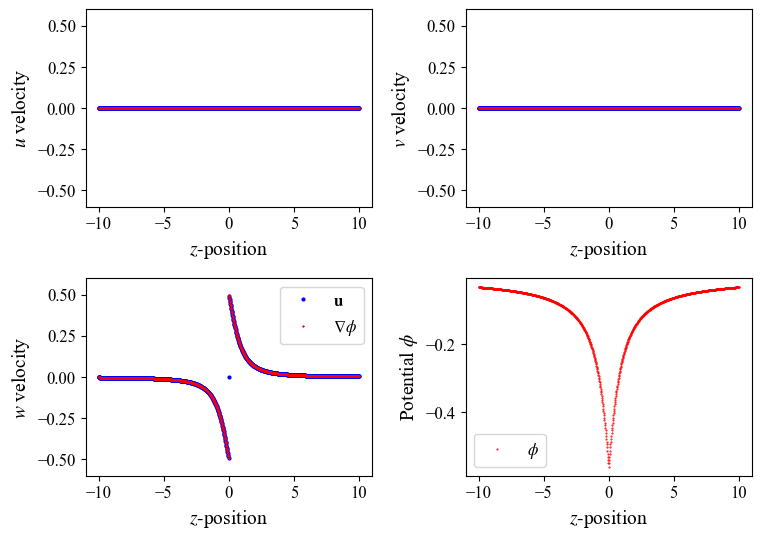

In [3]:
# Nodes of planar panel
nodes = [
            -1 -1 0;
             1 -1 0;
             1  1 0;
            -1  1 0;
        ]'
nnodes = size(nodes, 2)

panel = collect(1:nnodes)

# Translate and rotate panel
O = zeros(3)
Oaxis = pnl.gt.rotation_matrix(0, 0, 0)
# O = ones(3)
# Oaxis = pnl.gt.rotation_matrix(30, 40, 60)
# Oaxis = pnl.gt.rotation_matrix(30, 40, 60)
nodes = Oaxis'*nodes + repeat(O, 1, nnodes)

# Unitary panel's strength
strength = 1.0

cellcenter = sum(eachcol(nodes)) / nnodes
normal = Oaxis'*[0, 0, 1]

# Define probe line
ntargets = 1001
Xoff = 0.25*[1, 1, 0]*0
# tilt = pnl.gt.rotation_matrix(30, 0, 0)
tilt = pnl.gt.rotation_matrix(0, 0, 0)
zs = range(-10, 10, length=ntargets)
Xs = [(cellcenter + Xoff) + z*tilt'*normal for z in zs]


# Compute analytical velocity
targets = hcat(Xs...)
U_ana = zeros(3, ntargets)

pnl.U_constant_source(nodes, panel, strength, targets, U_ana; offset=0)

# Compute potential field
phis = zeros(ntargets)
pnl.phi_constant_source(nodes, panel, strength, targets, phis; offset=0)

# Compute gradient of potential field
function fwrap(X::Array{R, 1}) where {R}
    targs = reshape(X, 3, 1)
    phis = zeros(R, 1)
    pnl.phi_constant_source(nodes, panel, strength, targs, phis; offset=0)
    return phis
end

function eval_Udiff(X)

    Nin = 3                        # Number of inputs
    Nout = 1                       # Number of outputs
    cfg = FD.JacobianConfig(nothing, X, FD.Chunk{Nin}())

    J = zeros(Nout, Nin)           # Stores the Jacobian here, J[i,j]=dfi/dxj
    FD.jacobian!(J, fwrap, X, cfg)
    Udiff = reshape(J, 3, 1)          # Velocity from automatic differentiation
    
    return Udiff
end

U_diff = hcat([eval_Udiff(X) for X in eachcol(targets)]...)


# Plot probed velocity and potential fields
fig = plt.figure(figsize=[7*2, 5*2]*5/9)
axs = fig.subplots(2, 2)
axs = [axs[j, i] for i in 1:size(axs, 1), j in 1:size(axs, 2)]

for (axi, ax) in enumerate(axs[1:3])
    ax.plot(zs, U_ana[axi, :], "ob", markersize=2, label=L"\mathbf{u}")
    ax.plot(zs, U_diff[axi, :], "*r", markersize=1, label=L"\nabla \phi")
    
    ax.set_xlabel(L"$z$-position")
    ax.set_ylabel([L"u", L"v", L"w"][axi]*" velocity")
    ax.set_ylim(0.6*[-1, 1])
    ax.set_yticks(-0.5:0.25:0.5)
end

axs[3].legend(loc="best", frameon=true)

ax = axs[4]
ax.plot(zs, phis, ".r", markersize=1, label=L"\phi")
ax.set_xlabel(L"$z$-position")
ax.set_ylabel(L"Potential $\phi$")
ax.legend(loc="best", frameon=true)

fig.tight_layout()

# Evaluate potential field at z=0 and z=inf
h = 1e-8
targets = [0 0 0; 0 0 1e10; 0 0 h]'
phis = zeros(3)
pnl.phi_constant_source(nodes, panel, strength, targets, phis; offset=0)

dphidz = (phis[3] - phis[1])/h

println("phi at z=inf:\t\t$(phis[2])")
println("phi at z=0:\t\t$(phis[1])")
println("dphi/dz at z=$(sign(h)==1 ? "+" : "-")0:\t$(dphidz)")
println("sigma:\t\t\t$(strength)")
println("dphi/dz == $(sign(h)==1 ? "+" : "-")sigma/2 ? \t$(abs(dphidz - sign(h)*strength/2) < 1e-4)")

### Verification &ndash; Induced flow direction

In [4]:
save_path = "temps/"
file_name = "sourcepanel00"

# Nodes of planar panel
nodes = [ 
            0 0 0;
            0.8 0 0;
            1 0.8 0;
            0.4 1.2 0;
            0 1 0;
        ]'
nnodes = size(nodes, 2)

panel = collect(1:nnodes)

# Translate and rotate panel
O = ones(3)
Oaxis = gt.rotation_matrix(30, 0, 0)
nodes = Oaxis'*nodes + repeat(O, 1, nnodes)

# Unitary panel's strength
strength = 1.0

# Defines a grid for proving the velocity
P_max = [1.5, 1.5, 0.5]                     # Upper bound
P_min = [-.5, -.5, -.5]                     # Lower bound
NDIVS = 56*[2, 2, 1]                        # Divisions in each dimension
grid = gt.Grid(P_min, P_max, NDIVS)   # Grid

gt.lintransform!(grid, Oaxis, O)

# Targets where to prove the velocity
targets = grid.nodes
ntargets = size(targets, 2)

# Array where to store velocities
phis = zeros(ntargets)
Us = zeros(3, ntargets)

# Calculates velocities
pnl.phi_constant_source(nodes, panel, strength, targets, phis; offset=0)
pnl.U_constant_source(nodes, panel, strength, targets, Us; offset=0)

# Saves velocities into the grid
gt.add_field(grid, "phi", "scalar", phis, "node")
gt.add_field(grid, "U", "vector", collect(eachcol(Us)), "node")

# Normal vector
normal = gt._calc_normal(collect(eachcol(nodes)))
cell_data = [Dict(  "field_name" => "normal",
                    "field_type" => "vector",
                    "field_data" => [normal])]

point_data = [Dict( "field_name" => "index",
                    "field_type" => "scalar",
                    "field_data" => [i for i in 1:nnodes])]

str = save_path*"/"

# Outputs vtks
str *= gt.generateVTK(file_name*"_panel", collect(eachcol(nodes)); path=save_path, 
                        cells=[[i-1 for i in 1:nnodes]], cell_data=cell_data, point_data=point_data)
str *= gt.save(grid, file_name*"_grid"; path=save_path)

# Open vtks
run(`paraview --data=$str`)

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


VisRTX 0.1.6, using devices:
 0: NVIDIA RTX A3000 Laptop GPU (Total: 6.2 GB, Available: 6.1 GB)


Process(`paraview '--data=temps//sourcepanel00_panel.vtk;sourcepanel00_grid.xmf;'`, ProcessExited(0))

## Constant-Strength Doublet Panel (or Vortex Ring)

Recall that the potential field induced by doublets is given by 


\begin{align*}
        \phi_\mu(\mathbf{x})
    = %
        \frac{f_{\tiny \partial V_b}(\mathbf{x})}{\pi }
        \int\limits_{\partial V_b} 
            \mu \hat{\mathbf{n}} \cdot  \nabla \left(\frac{1}{r}\right) 
        \,\mathrm{d}S
,\end{align*}

while the component induced by sources is

\begin{align*}
        \phi_\sigma(\mathbf{x})
    = %
        -\frac{f_{\tiny \partial V_b}(\mathbf{x})}{\pi }
        \int\limits_{\partial V_b} 
            \sigma \frac{1}{r}
        \,\mathrm{d}S
.\end{align*}

Assuming constant-strength panels, each strength comes out of the integrals and we rewrite the above equations as

\begin{align*}
        \phi_\mu(\mathbf{x})
    = %
        \mu G_\mu (\mathbf{x})
    \quad , \quad
        G_\mu (\mathbf{x})
    \equiv
        \frac{f_{\tiny \partial V_b}(\mathbf{x})}{\pi }
        \int\limits_{\partial V_b} 
             \hat{\mathbf{n}} \cdot  \nabla \left(\frac{1}{r}\right) 
        \,\mathrm{d}S
,\end{align*}

and


\begin{align*}
        \phi_\sigma(\mathbf{x})
    = %
        \sigma G_\sigma (\mathbf{x})
    \quad , \quad
        G_\sigma (\mathbf{x})
    \equiv
        -\frac{f_{\tiny \partial V_b}(\mathbf{x})}{\pi }
        \int\limits_{\partial V_b} 
            \frac{1}{r}
        \,\mathrm{d}S
,\end{align*}

Notice that computation of the potential field induced by the doublet element is similar to the computation of the normal velocity induced by the source element:

\begin{align*}
        \hat{\mathbf{n}} \cdot \nabla\phi_\sigma
    =
        -\sigma \frac{f_{\tiny \partial V_b}}{\pi }
        \int\limits_{\partial V_b} 
            \hat{\mathbf{n}} \cdot \nabla \left(
                \frac{1}{r}
            \right)
        \,\mathrm{d}S
    =
        -\sigma G_\mu.
\end{align*}

Hence, we can simply reuse the computation of the source-induced velocity to calculate the potential of the doublet element as

\begin{align*}
        \phi_\mu
    =
        -\mu \frac{\hat{\mathbf{n}} \cdot \mathbf{u}_\sigma}{\sigma}
,\end{align*}

where $\hat{\mathbf{n}} \cdot \mathbf{u}_\sigma = U_z$ with $U_z$ as defined in the previous section.

In order to calculate the velocity field induced by the doublet, instead of calculating $\nabla\phi_\mu$ we take advantage of the fact that the velocity induced by a constant-strength doublet panel is the same than the velocity induced by a vortex ring (see Katz and Plotkin Sec. 10.4.3),


\begin{align}
        \mathbf{u}_\mathrm{ring} \left( \mathbf{x} \right)
    =
        \frac{\Gamma}{4\pi} 
        \sum\limits_{i,j\in A}
            \frac{\mathbf{r}_i \times \mathbf{r}_j}{ \Vert \mathbf{r}_i \times \mathbf{r}_j \Vert^2}
            \mathbf{r}_{ij} \cdot \left(
                \frac{\mathbf{r}_i}{r_i} - \frac{\mathbf{r}_j}{r_j}
            \right)
,\end{align}

when $\Gamma = \mu$, and where $\mathbf{r}_{ij} = \mathbf{p}_j-\mathbf{p}_i$, $\mathbf{r}_i = \mathbf{x} - \mathbf{p}_i$, $\mathbf{r}_j = \mathbf{x} - \mathbf{p}_j$, $A = \{(1,2),\,\dots,\,(n-1, n),\,(n, 1) \}$ and $n$ the number of vertices that make the panel, each with position $\mathbf{p}_k$.

> **NOTE:** For the same reasons explained in the previous section, $\phi_\mu$ poses a discontinuity at the surface since $\lim\limits_{z\rightarrow \pm 0} \phi_\mu (0, 0, z) = -\frac{\mu}{\sigma} \lim\limits_{z\rightarrow \pm 0} U_z (0, 0, z) = \mp \frac{\mu}{2}$. In FLOWPanel, we let $\phi_\mu (0, 0, 0) = 0$, but we also have shifted all control points slightly in the direction of $\hat{\mathbf{n}}$. Remembering that $\hat{\mathbf{n}}_\mathrm{HS} = -\hat{\mathbf{n}}$, the control points are thus shifted in the $-z$ direction, effectively obtaining $\boxed{\phi_\mu (\mathbf{x}_\mathrm{cp}) \approx \frac{\mu}{2}}$.

**OBSERVATIONS**
* The velocity induced by a segment of the vortex ring shown above becomes singular when the denominator terms $r_i$, $r_j$, or $\Vert \mathbf{r}_i \times \mathbf{r}_j \Vert$  approach $0$. For this reason, FLOWPanel adds a small epsilon to each of these terms, while also defining a cutoff threshold for $\Vert \mathbf{r}_i \times \mathbf{r}_j \Vert$ under which the velocity induced becomes $0$ (thus, self-induced velocity is forced to be zero).

> **NOTE:** The small offset added to the denominator terms $r_i$, $r_j$, and $\Vert \mathbf{r}_i \times \mathbf{r}_j \Vert$ corresponds to `body.kerneloffset`, while the cutoff threshold for self-induced velocity corresponds to `body.kernelcutoff`.

The potential and velocity field of a doublet panel of unitary strength ($\mu=1$) is shown below

<table>
    <tr>
        <th>
            <center>Potential $\phi(\mathbf{x})$</center>
        </th>
        <th>
            <center>Velocity $\mathbf{u}(\mathbf{x})$</center>
        </th>
    </tr>
    <tr>
        <th>
            <img src="img/panel-doublet-phi02.png" alt="Pic here" width="450px">
        </th>
        <th>
            <img src="img/panel-doublet-u01.png" alt="Pic here" width="300px">
        </th>
    </tr>
</table>

### Verification &ndash; $\nabla \phi$ vs $\mathbf{u}$

phi at z=inf:		0.0
phi at z=0:		0.0
phi at z=+0:		-0.4999999954984184
mu:			1.0
phi(+0) == -mu/2 ? 	true


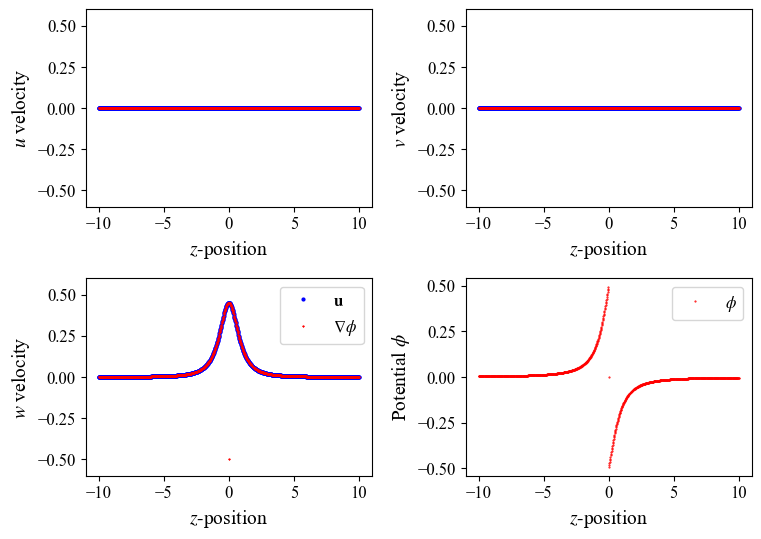

In [5]:
# Nodes of planar panel
nodes = [
            -1 -1 0;
             1 -1 0;
             1  1 0;
            -1  1 0;
        ]'
nnodes = size(nodes, 2)

panel = collect(1:nnodes)

# Translate and rotate panel
O = zeros(3)
Oaxis = pnl.gt.rotation_matrix(0, 0, 0)
# O = ones(3)
# Oaxis = pnl.gt.rotation_matrix(30, 40, 60)
# Oaxis = pnl.gt.rotation_matrix(30, 40, 60)
nodes = Oaxis'*nodes + repeat(O, 1, nnodes)

# Unitary panel's strength
strength = 1.0

cellcenter = sum(eachcol(nodes)) / nnodes
normal = Oaxis'*[0, 0, 1]

# Define probe line
ntargets = 1001
Xoff = 0.25*[1, 1, 0]*0
# tilt = pnl.gt.rotation_matrix(30, 0, 0)
tilt = pnl.gt.rotation_matrix(0, 0, 0)
zs = range(-10, 10, length=ntargets)
Xs = [(cellcenter + Xoff) + z*tilt'*normal for z in zs]


# Compute analytical velocity
targets = hcat(Xs...)
U_ana = zeros(3, ntargets)

pnl.U_constant_doublet(nodes, panel, strength, targets, U_ana; offset=0, cutoff=0)

# Compute potential field
phis = zeros(ntargets)
pnl.phi_constant_doublet(nodes, panel, strength, targets, phis)

# Compute gradient of potential field
function fwrap(X::Array{R, 1}) where {R}
    targs = reshape(X, 3, 1)
    phis = zeros(R, 1)
    pnl.phi_constant_doublet(nodes, panel, strength, targs, phis)
    return phis
end

function eval_Udiff(X)

    Nin = 3                        # Number of inputs
    Nout = 1                       # Number of outputs
    cfg = FD.JacobianConfig(nothing, X, FD.Chunk{Nin}())

    J = zeros(Nout, Nin)           # Stores the Jacobian here, J[i,j]=dfi/dxj
    FD.jacobian!(J, fwrap, X, cfg)
    Udiff = reshape(J, 3, 1)          # Velocity from automatic differentiation
    
    return Udiff
end

U_diff = hcat([eval_Udiff(X) for X in eachcol(targets)]...)


# Plot probed velocity and potential fields
fig = plt.figure(figsize=[7*2, 5*2]*5/9)
axs = fig.subplots(2, 2)
axs = [axs[j, i] for i in 1:size(axs, 1), j in 1:size(axs, 2)]

for (axi, ax) in enumerate(axs[1:3])
    ax.plot(zs, U_ana[axi, :], "ob", markersize=2, label=L"\mathbf{u}")
    ax.plot(zs, U_diff[axi, :], "*r", markersize=1, label=L"\nabla \phi")
    
    ax.set_xlabel(L"$z$-position")
    ax.set_ylabel([L"u", L"v", L"w"][axi]*" velocity")
    ax.set_ylim(0.6*[-1, 1])
    ax.set_yticks(-0.5:0.25:0.5)
end

axs[3].legend(loc="best", frameon=true)

ax = axs[4]
ax.plot(zs, phis, ".r", markersize=1, label=L"\phi")
ax.set_xlabel(L"$z$-position")
ax.set_ylabel(L"Potential $\phi$")
ax.legend(loc="best", frameon=true)

fig.tight_layout()

# Evaluate potential field at z=0 and z=inf
h = 1e-8
targets = [0 0 0; 0 0 1e10; 0 0 h]'
phis = zeros(3)
pnl.phi_constant_doublet(nodes, panel, strength, targets, phis)

phidz = phis[3]

println("phi at z=inf:\t\t$(phis[2])")
println("phi at z=0:\t\t$(phis[1])")
println("phi at z=$(sign(h)==1 ? "+" : "-")0:\t\t$(phidz)")
println("mu:\t\t\t$(strength)")
println("phi($(sign(h)==1 ? "+" : "-")0) == $(sign(h)==1 ? "-" : "+")mu/2 ? \t$(abs(phidz + sign(h)*strength/2) < 1e-4)")

### Verification &ndash; Induced flow direction

In [6]:
save_path = "temps/"
file_name = "doubletpanel01"

# Nodes of planar panel
nodes = [ 
            0 0 0;
            0.8 0 0;
            1 0.8 0;
            0.4 1.2 0;
            0 1 0;
        ]'
nnodes = size(nodes, 2)

panel = collect(1:nnodes)

# Translate and rotate panel
O = ones(3)
Oaxis = gt.rotation_matrix(30, 0, 0)
nodes = Oaxis'*nodes + repeat(O, 1, nnodes)

# Unitary panel's strength
strength = 1.0

# Defines a grid for proving the velocity
P_max = [1.5, 1.5, 0.5]                     # Upper bound
P_min = [-.5, -.5, -.5]                     # Lower bound
NDIVS = 56*[2, 2, 1]                        # Divisions in each dimension
grid = gt.Grid(P_min, P_max, NDIVS)   # Grid

gt.lintransform!(grid, Oaxis, O)

# Targets where to prove the velocity
targets = grid.nodes
ntargets = size(targets, 2)

# Array where to store velocities
phis = zeros(ntargets)
Us = zeros(3, ntargets)

# Calculates velocities
pnl.phi_constant_doublet(nodes, panel, strength, targets, phis)
pnl.U_constant_doublet(nodes, panel, strength, targets, Us; offset=2e-2, cutoff=1e-5)

# Saves velocities into the grid
gt.add_field(grid, "phi", "scalar", phis, "node")
gt.add_field(grid, "U", "vector", collect(eachcol(Us)), "node")

# Normal vector
normal = gt._calc_normal(collect(eachcol(nodes)))
cell_data = [Dict(  "field_name" => "normal",
                    "field_type" => "vector",
                    "field_data" => [normal])]

point_data = [Dict( "field_name" => "index",
                    "field_type" => "scalar",
                    "field_data" => [i for i in 1:nnodes])]

str = save_path*"/"

# Outputs vtks
str *= gt.generateVTK(file_name*"_panel", collect(eachcol(nodes)); path=save_path, 
                        cells=[[i-1 for i in 1:nnodes]], cell_data=cell_data, point_data=point_data)
str *= gt.save(grid, file_name*"_grid"; path=save_path)

# Open vtks
run(`paraview --data=$str`)

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


VisRTX 0.1.6, using devices:
 0: NVIDIA RTX A3000 Laptop GPU (Total: 6.2 GB, Available: 6.1 GB)


Process(`paraview '--data=temps//doubletpanel01_panel.vtk;doubletpanel01_grid.xmf;'`, ProcessExited(0))

## Semi-Infinite Doublet Panel (or Vortex Horseshoe)

(Adapted fron Moran, J. (1984), *An introduction to theoretical and computational aerodynamics*, Appendix F, p. 442)

Assume a constant-strength doublet panel that starts from $\mathbf{p}_a$ and $\mathbf{p}_b$ and extends infinitely in the $x$ direction laying in the $xy$-plane, as shown below. Since a finite doublet panel is the same than a vortex ring, the semi-infinite doublet panel corresponds to a horseshoe vortex.

<img src="img/seminfinitevortex00.png" alt="Pic here" width="400px">

> **NOTE:** In order to have the normal of the doublet panel pointing in the $+z$ direction while having the horseshoe vortex going in the direction shown above (coming from $\infty$ to $a$, from $a$ to $b$, and going out from $b$ to $\infty$), we have to define $\boxed{\mu = -\Gamma}$.

Since the potential of a point doublet corresponds to the negative normal-derivative of the potential of a point source,

\begin{align*}
        \phi_{\text{point }\mu} 
    = 
        - \mu \frac{\partial}{\partial z}\left( -\frac{1}{4\pi r} \right) 
    = 
        -\frac{\mu}{4\pi}\frac{z}{r^3}
,\end{align*}

the potential of the semi-infinite constant-strength doublet panel is given by

\begin{align*}
        \phi_{\mu} (x,\, y,\, z)
    = 
        -\frac{\mu}{4\pi}
        \int\limits_{y_a}^{y_b}
            \int\limits_{x_a}^{\infty}
                \frac{z}{\left[ (x-x')^2 + (y-y')^2 + z^2 \right]^{3/2}}
            \,\mathrm{d} x'
        \,\mathrm{d} y'
.\end{align*}

According to Moran (p. 445), this integral becomes

\begin{align*}
        \phi_{\mu} (x,\, y,\, z)
    = 
        -\frac{\mu}{4\pi}
        \left. \left[
            \tan^{-1}\left( \frac{y'-y}{z} \right)
            +
            \tan^{-1}\left( \frac{ (y'-y)(x-x_a) }{ z \sqrt{(x-x_a)^2 + (y'-y)^2 + z^2} } \right)
        \right]\right\vert_{y_a}^{y_b}
.\end{align*}

> **NOTE:** $\tan^{-1}$ here is for outputs in the range $-\frac{\pi}{2}$ to $\frac{\pi}{2}$.

In the derivation above we have assumed that the bound vortex section $\mathbf{p}_b - \mathbf{p}_a$ is perpendicular to the semi-infinite direction $\hat{\mathbf{d}}_\infty$. That is, $\hat{\mathbf{d}}_\infty\cdot(\mathbf{p}_b - \mathbf{p}_a)=0$. This is in general not true since $\mathbf{p}_b - \mathbf{p}_a$ typically represents the trailing edge while $\hat{\mathbf{d}}_\infty$ is the direction of the freestream.

Given two arbitrary nodes $\mathbf{p}_i$ and $\mathbf{p}_j$ along the trailing edge and an arbitrary freestream direction $\hat{\mathbf{d}}_\infty$ as shown below (left), we define $\mathbf{p}_a$ as the closest point to $\mathbf{p}_j$ along the incoming semi-infinite vortex, as shown below (right).

<table>
    <tr>
        <th>
            <center></center>
        </th>
        <th>
            <center></center>
        </th>
    </tr>
    <tr>
        <th>
            <img src="img/semiinfinite-doublet02.png" alt="Pic here" width="450px">
        </th>
        <th>
            <img src="img/semiinfinite-doublet01.png" alt="Pic here" width="450px">
        </th>
    </tr>
</table>

This point is calculated as

\begin{align*}
        \mathbf{p}_a 
    = 
        \mathbf{p}_i + \left[ (\mathbf{p}_j - \mathbf{p}_i) \cdot \hat{\mathbf{d}}_\infty \right] \hat{\mathbf{d}}_\infty
,\end{align*}

which defines a bound vortex $\mathbf{p}_j - \mathbf{p}_a$ that is perpendicular to $\hat{\mathbf{d}}_\infty$. This bound vortex is used to define the following local coordinate system 

\begin{align*}
    \bullet \quad &
        \hat{\mathbf{x}} = \hat{\mathbf{d}}_\infty
    \\
    \bullet \quad &
        \hat{\mathbf{y}} = \frac{\mathbf{p}_b - \mathbf{p}_a}{\Vert \mathbf{p}_b - \mathbf{p}_a \Vert}
    \\
    \bullet \quad &
        \hat{\mathbf{z}} = \hat{\mathbf{x}} \times \hat{\mathbf{y}}
\end{align*}

where $\mathbf{p}_b = \mathbf{p}_j$.

The potential induced by this elements is then computed as the superposition of potential of the doublet panel defined by the vertices $\mathbf{p}_a$, $\mathbf{p}_i$, and $\mathbf{p}_j$ and the potential induced by the semi-infinite panel starting between $\mathbf{p}_a$ and $\mathbf{p}_j$.

> **NOTE:** The doublet panel is purposely defined in the order $\mathbf{p}_a$, $\mathbf{p}_i$, and $\mathbf{p}_j$ as to define its normal through the right-hand rule as $\hat{\mathbf{n}}=-\hat{\mathbf{z}}$ and have the associated vortex ring matching the figure above.

The induced velocity is calculated as the velocity induced by a bound vortex between $\mathbf{p}_i$ and $\mathbf{p}_j$, plus the velocity induced by two semi-infinite vortices coming in and out of $\mathbf{p}_i$ and $\mathbf{p}_j$, respectively.

The velocity of the bound vortex is calculated as

\begin{align}
        \mathbf{u}_\mathrm{ij} \left( \mathbf{x} \right)
    =
        \frac{\Gamma}{4\pi} 
            \frac{\mathbf{r}_i \times \mathbf{r}_j}{ \Vert \mathbf{r}_i \times \mathbf{r}_j \Vert^2}
            \mathbf{r}_{ij} \cdot \left(
                \frac{\mathbf{r}_i}{r_i} - \frac{\mathbf{r}_j}{r_j}
            \right)
,\end{align}

where $\Gamma = \mu$, $\mathbf{r}_{ij} = \mathbf{p}_j-\mathbf{p}_i$, $\mathbf{r}_i = \mathbf{x} - \mathbf{p}_i$, $\mathbf{r}_j = \mathbf{x} - \mathbf{p}_j$. The velocity of a semi-infinite vortex is calculated as follows.

Assume a semi-infinite vortex starting at $\mathbf{p}_0$ and extending in the direction $\hat{\mathbf{d}}$.
Given a position $\mathbf{x}$ that is aligned with the starting point $\mathbf{p}_0$ (by *aligned* we mean that both $\mathbf{x}$ and $\mathbf{p}_0$ lay in a plane with normal $\hat{\mathbf{d}}$), the velocity that the semi-infinite vortex induces at $\mathbf{x}$ is calculated as

\begin{align}
    \mathbf{u}_{\infty/2}\left( \mathbf{x} \right) = \frac{\Gamma}{4 \pi h} \hat{\mathbf{n}}
,\end{align}

where $\Gamma$ is the vortex strength, $h = \Vert \mathbf{x} - \mathbf{p}_0 \Vert$ the normal distance to the vortex line, $\hat{\mathbf{n}} \equiv \hat{\mathbf{d}}\times\hat{\mathbf{h}}$ is the vector normal to the plane defined by $\hat{\mathbf{d}}$ and $\hat{\mathbf{h}}$, and $\hat{\mathbf{h}} \equiv \frac{\mathbf{x}-\mathbf{p}_0}{\Vert \mathbf{x}-\mathbf{p}_0 \Vert}$. Note that in this definition, **a positive $\Gamma$ denotes the vortex going out from $\mathbf{p}_0$ to $\infty$**.

If $\mathbf{x}$ is not aligned with ("in the same plane than") the start of the semi-infinite vortex $\mathbf{p}$, the semi-infinite vortex is arbitrarely split up such that $\mathbf{p}_0$ is found by projecting $\mathbf{x}$ into the line vortex as

\begin{align}
    \mathbf{p}_0 =  \mathbf{p} + \left[ \left( \mathbf{x} - \mathbf{p} \right) \cdot \hat{\mathbf{d}} \right]  \hat{\mathbf{d}}
,\end{align}

where $\mathbf{p}$ was the original starting point.
Thus, the semi-infinite vortex is split up into two section: one bound vortex between $\mathbf{p}_0$ and $\mathbf{p}$, and a semi-infinite section starting from $\mathbf{p}_0$ as shown below.

<img src="img/semiinfinite-vortex01.png" alt="Pic here" style="width: 350px;"/>

Thus, the velocity is calculated as 

\begin{align}
    \mathbf{u}\left( \mathbf{x} \right) & = 
        \mathbf{u}_{\mathbf{p}_0\mathbf{p}}\left( \mathbf{x} \right) +
            \mathbf{u}_{\infty/2}\left( \mathbf{x} \right)
.\end{align}

**OBSERVATIONS**
* The velocity induced by both bound and semi-infinite vortices are singular as $\mathbf{x}$ becomes collinear with the vortex. The singularity is avoided by adding a small offset $\epsilon$ to $h$ in the semi-infinite vortex and to each denominator in the calculation of the bound vortex.
* Since the velocity induced by a vortex on itself must be zero, we also define a small threshold close to both the bound and semi-infinite vortices at which the velocity induced at $\mathbf{x}$ becomes zero.


> **NOTE:** The small offset $\epsilon$ corresponds to `body.kerneloffset`, while the cutoff threshold for self-induced velocity corresponds to `body.kernelcutoff`.

The potential and velocity field of a semi-infinte doublet panel (or vortex horseshoe) of unitary strength ($\mu=1$ or $\Gamma=1$) is shown below

<table>
    <tr>
        <th>
            <center>Potential $\phi(\mathbf{x})$</center>
        </th>
        <th>
            <center>Velocity $\mathbf{u}(\mathbf{x})$</center>
        </th>
    </tr>
    <tr>
        <th>
            <img src="img/panel-semiinfinite-doublet-phi01.png" alt="Pic here" width="450px">
        </th>
        <th>
            <img src="img/panel-semiinfinite-doublet-u01.png" alt="Pic here" width="450px">
        </th>
    </tr>
</table>

### Verification &mdash; Semi-Infinite Panel vs Very-Large Panel

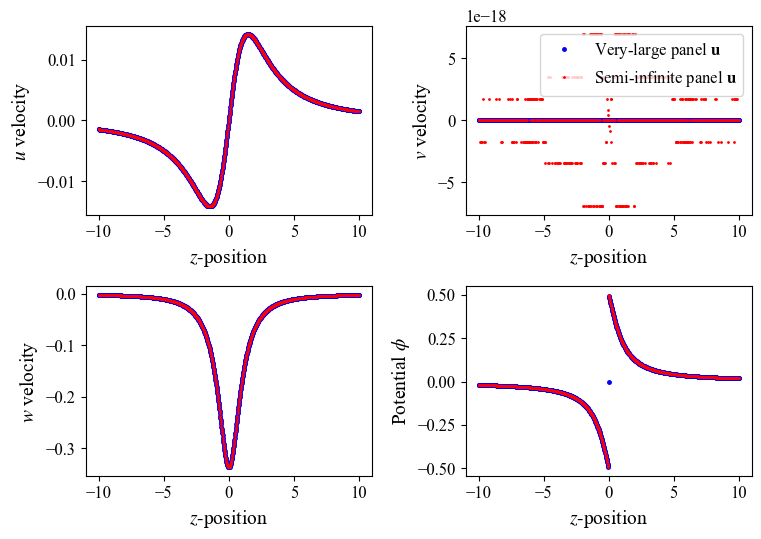

In [7]:
# Nodes of panels
nodes = [
             0 -1 0;
             0  1 0;
             9999  1 0;
             9999  -1 0;
        ]'
nnodes = size(nodes, 2)
panel = collect(1:nnodes)

TE = collect(1:2)     # Indices of nodes that make the trailing edge
dhat = [1, 0, 0]      # Semi-infinite direction

# Translate and rotate panel
O = zeros(3)
Oaxis = pnl.gt.rotation_matrix(0, 0, 0)
# O = ones(3)
# Oaxis = pnl.gt.rotation_matrix(30, 40, 60)
# Oaxis = pnl.gt.rotation_matrix(30, 40, 60)

nodes = Oaxis'*nodes + repeat(O, 1, nnodes)
dhat = Oaxis'*dhat

# Unitary panel's strength
strength = 1.0

cellcenter = Oaxis'*[2, 0, 0] + O
# cellcenter = Oaxis'*[0, 0, 0] + O
# normal = Oaxis'*[0, 0, -1]
normal = Oaxis'*[0, 0, 1]

# Define probe line
ntargets = 1001
Xoff = 0.25*[1, 1, 0]*0
# tilt = pnl.gt.rotation_matrix(30, 0, 0)
tilt = pnl.gt.rotation_matrix(0, 0, 0)
zs = range(-10, 10, length=ntargets)
Xs = [(cellcenter + Xoff) + z*tilt'*normal for z in zs]

targets = hcat(Xs...)

# Compute potential and velocity field of semi-infinite panel
phi_inf = zeros(ntargets)
pnl.phi_semiinfinite_doublet(nodes, TE, dhat..., strength, targets, phi_inf)

U_inf = zeros(3, ntargets)
pnl.U_semiinfinite_doublet(nodes, TE, dhat..., strength, targets, U_inf; offset=0, cutoff=0)

# Approximate potential and velocity field with a very large panel
phi_big = zeros(ntargets)
pnl.phi_constant_doublet(nodes, panel, strength, targets, phi_big)

U_big = zeros(3, ntargets)
pnl.U_constant_doublet(nodes, panel, strength, targets, U_big; offset=0, cutoff=0)



# Plot probed velocity and potential fields
fig = plt.figure(figsize=[7*2, 5*2]*5/9)
axs = fig.subplots(2, 2)
axs = [axs[j, i] for i in 1:size(axs, 1), j in 1:size(axs, 2)]

for (axi, ax) in enumerate(axs[1:3])
    ax.plot(zs, U_big[axi, :], ".b", markersize=5, label=L"Very-large panel $\mathbf{u}$")
    ax.plot(zs, U_inf[axi, :], ".r", markersize=2, label=L"Semi-infinite panel $\mathbf{u}$")
    
    ax.set_xlabel(L"$z$-position")
    ax.set_ylabel([L"u", L"v", L"w"][axi]*" velocity")
#     ax.set_ylim(0.6*[-1, 1])
#     ax.set_yticks(-0.5:0.25:0.5)
end

axs[2].legend(loc="best", frameon=true)

ax = axs[4]
ax.plot(zs, phi_big, ".b", markersize=5, label=L"Very-large panel $\phi$")
ax.plot(zs, phi_inf, ".r", markersize=2, label=L"Semi-infinite panel $\phi$")
ax.set_xlabel(L"$z$-position")
ax.set_ylabel(L"Potential $\phi$")
# ax.legend(loc="best", frameon=true)
# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=false)

fig.tight_layout()

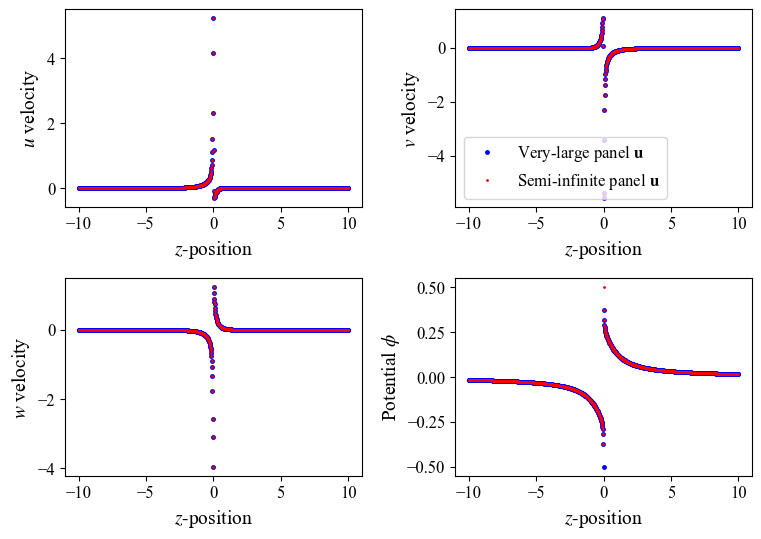

In [8]:
# Nodes of panels
nodes = [
             -100 -1 0;
             100  1 0;
             9999  1 0;
             9999  -1 0;
        ]'
nnodes = size(nodes, 2)
panel = collect(1:nnodes)

TE = collect(1:2)     # Indices of nodes that make the trailing edge
dhat = [1, 0, 0]      # Semi-infinite direction

# Translate and rotate panel
O = zeros(3)
# Oaxis = pnl.gt.rotation_matrix(0, 0, 0)
# O = ones(3)
Oaxis = pnl.gt.rotation_matrix(30, 40, 60)
# Oaxis = pnl.gt.rotation_matrix(30, 40, 60)

nodes = Oaxis'*nodes + repeat(O, 1, nnodes)
dhat = Oaxis'*dhat

# Unitary panel's strength
strength = 1.0

cellcenter = Oaxis'*[2, 0, 0] + O
# cellcenter = Oaxis'*[0, 0, 0] + O
# normal = Oaxis'*[0, 0, -1]
normal = Oaxis'*[0, 0, 1]

# Define probe line
ntargets = 1001
Xoff = 0.25*[1, 1, 0]*0
# tilt = pnl.gt.rotation_matrix(30, 0, 0)
tilt = pnl.gt.rotation_matrix(0, 0, 0)
zs = range(-10, 10, length=ntargets)
Xs = [(cellcenter + Xoff) + z*tilt'*normal for z in zs]

targets = hcat(Xs...)

# Compute potential and velocity field of semi-infinite panel
phi_inf = zeros(ntargets)
pnl.phi_semiinfinite_doublet(nodes, TE, dhat..., strength, targets, phi_inf)

U_inf = zeros(3, ntargets)
pnl.U_semiinfinite_doublet(nodes, TE, dhat..., strength, targets, U_inf; offset=0, cutoff=0)

# Approximate potential and velocity field with a very large panel
phi_big = zeros(ntargets)
pnl.phi_constant_doublet(nodes, panel, strength, targets, phi_big)

U_big = zeros(3, ntargets)
pnl.U_constant_doublet(nodes, panel, strength, targets, U_big; offset=0, cutoff=0)



# Plot probed velocity and potential fields
fig = plt.figure(figsize=[7*2, 5*2]*5/9)
axs = fig.subplots(2, 2)
axs = [axs[j, i] for i in 1:size(axs, 1), j in 1:size(axs, 2)]

for (axi, ax) in enumerate(axs[1:3])
    ax.plot(zs, U_big[axi, :], ".b", markersize=5, label=L"Very-large panel $\mathbf{u}$")
    ax.plot(zs, U_inf[axi, :], ".r", markersize=2, label=L"Semi-infinite panel $\mathbf{u}$")
    
    ax.set_xlabel(L"$z$-position")
    ax.set_ylabel([L"u", L"v", L"w"][axi]*" velocity")
#     ax.set_ylim(0.6*[-1, 1])
#     ax.set_yticks(-0.5:0.25:0.5)
end

axs[2].legend(loc="best", frameon=true)

ax = axs[4]
ax.plot(zs, phi_big, ".b", markersize=5, label=L"Very-large panel $\phi$")
ax.plot(zs, phi_inf, ".r", markersize=2, label=L"Semi-infinite panel $\phi$")
ax.set_xlabel(L"$z$-position")
ax.set_ylabel(L"Potential $\phi$")
# ax.legend(loc="best", frameon=true)
# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=false)

fig.tight_layout()

### Verification &ndash; $\nabla \phi$ vs $\mathbf{u}$

phi at z=inf:		-1.5915494309189536e-11
phi at z=0:		NaN
phi at z=+0:		-0.4999999958332695
mu:			1.0
phi(+0) == -mu/2 ? 	true


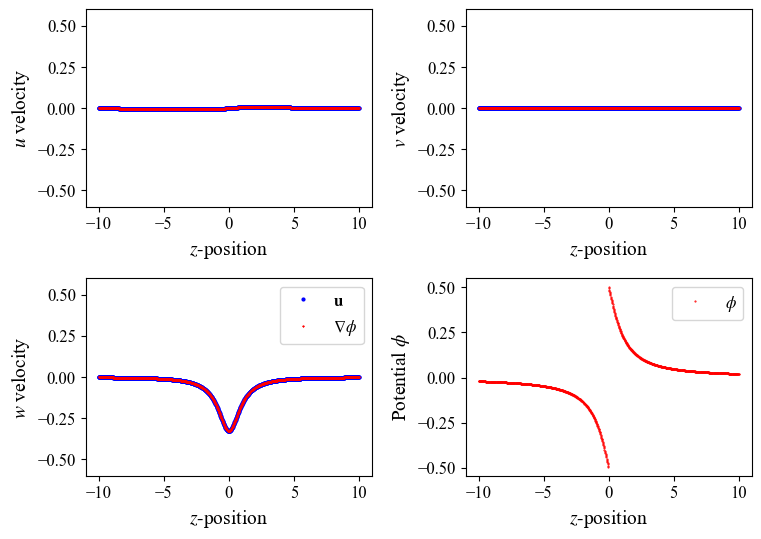

In [9]:
# Nodes of panels
nodes = [
             -2 -1 0;
             0  1 0;
             9999  1 0;
             9999  -1 0;
        ]'
nnodes = size(nodes, 2)
panel = collect(1:nnodes)

TE = collect(1:2)     # Indices of nodes that make the trailing edge
dhat = [1, 0, 0]      # Semi-infinite direction

# Translate and rotate panel
O = zeros(3)
Oaxis = pnl.gt.rotation_matrix(0, 0, 0)
# O = ones(3)
# Oaxis = pnl.gt.rotation_matrix(30, 40, 60)
# Oaxis = pnl.gt.rotation_matrix(30, 40, 60)

nodes = Oaxis'*nodes + repeat(O, 1, nnodes)
dhat = Oaxis'*dhat

# Unitary panel's strength
strength = 1.0

cellcenter = Oaxis'*[2, 0, 0] + O
# cellcenter = Oaxis'*[0, 0, 0] + O
# normal = Oaxis'*[0, 0, -1]
normal = Oaxis'*[0, 0, 1]

# Define probe line
ntargets = 1001
Xoff = 0.25*[1, 1, 0]*0
# tilt = pnl.gt.rotation_matrix(30, 0, 0)
tilt = pnl.gt.rotation_matrix(0, 0, 0)
zs = range(-10, 10, length=ntargets)
Xs = [(cellcenter + Xoff) + z*tilt'*normal for z in zs]

targets = hcat(Xs...)

# Compute analytical velocity
U_ana = zeros(3, ntargets)
pnl.U_semiinfinite_doublet(nodes, TE, dhat..., strength, targets, U_ana; offset=0, cutoff=0)

# Compute potential field
phis = zeros(ntargets)
pnl.phi_semiinfinite_doublet(nodes, TE, dhat..., strength, targets, phis)


# Compute gradient of potential field
function fwrap(X::Array{R, 1}) where {R}
    targs = reshape(X, 3, 1)
    phis = zeros(R, 1)
    pnl.phi_semiinfinite_doublet(nodes, TE, dhat..., strength, targs, phis)
    return phis
end

function eval_Udiff(X)

    Nin = 3                        # Number of inputs
    Nout = 1                       # Number of outputs
    cfg = FD.JacobianConfig(nothing, X, FD.Chunk{Nin}())

    J = zeros(Nout, Nin)           # Stores the Jacobian here, J[i,j]=dfi/dxj
    FD.jacobian!(J, fwrap, X, cfg)
    Udiff = reshape(J, 3, 1)          # Velocity from automatic differentiation
    
    return Udiff
end

U_diff = hcat([eval_Udiff(X) for X in eachcol(targets)]...)


# Plot probed velocity and potential fields
fig = plt.figure(figsize=[7*2, 5*2]*5/9)
axs = fig.subplots(2, 2)
axs = [axs[j, i] for i in 1:size(axs, 1), j in 1:size(axs, 2)]

for (axi, ax) in enumerate(axs[1:3])
    ax.plot(zs, U_ana[axi, :], "ob", markersize=2, label=L"\mathbf{u}")
    ax.plot(zs, U_diff[axi, :], "*r", markersize=1, label=L"\nabla \phi")
    
    ax.set_xlabel(L"$z$-position")
    ax.set_ylabel([L"u", L"v", L"w"][axi]*" velocity")
    ax.set_ylim(0.6*[-1, 1])
    ax.set_yticks(-0.5:0.25:0.5)
end

axs[3].legend(loc="best", frameon=true)

ax = axs[4]
ax.plot(zs, phis, ".r", markersize=1, label=L"\phi")
ax.set_xlabel(L"$z$-position")
ax.set_ylabel(L"Potential $\phi$")
ax.legend(loc="best", frameon=true)

fig.tight_layout()

# Evaluate potential field at z=0 and z=inf
normal = Oaxis'*[0, 0, -1]
h = 1e-8
# targets = [0 0 0; 0 0 1e10; 0 0 h]'
# targets = Oaxis'*hcat(zeros(3), [0, 0, 1e10], [0, 0, h])'  + O
targets = hcat(0*normal, 1e10*normal, h*normal)
phis = zeros(3)
pnl.phi_semiinfinite_doublet(nodes, TE, dhat..., strength, targets, phis)

phidz = phis[3]

println("phi at z=inf:\t\t$(phis[2])")
println("phi at z=0:\t\t$(phis[1])")
println("phi at z=$(sign(h)==1 ? "+" : "-")0:\t\t$(phidz)")
println("mu:\t\t\t$(strength)")
println("phi($(sign(h)==1 ? "+" : "-")0) == $(sign(h)==1 ? "-" : "+")mu/2 ? \t$(abs(phidz + sign(h)*strength/2) < 1e-4)")

### Verification &ndash; Induced flow direction

In [10]:
save_path = "temps/"
file_name = "semiinfinitedoubletpanel00"

# Nodes of panels
nodes = [
             0 -1 0;
             0  1 0;
             3  1 0;
             3  -1 0;
        ]'
nnodes = size(nodes, 2)
panel = collect(1:nnodes)

TE = collect(1:2)     # Indices of nodes that make the trailing edge
dhat = [1, 0, 0]      # Semi-infinite direction

# Translate and rotate panel
O = zeros(3)
Oaxis = gt.rotation_matrix(0, 0, 0)
# O = ones(3)
# Oaxis = gt.rotation_matrix(30, 0, 0)
nodes = Oaxis'*nodes + repeat(O, 1, nnodes)

# Unitary panel's strength
strength = 1.0

# Defines a grid for proving the velocity
P_max = [1.5, 1.5, 0.5]                     # Upper bound
P_min = [-0.5, -1.5, -0.5]                  # Lower bound
NDIVS = 56*[2, 2, 1]                        # Divisions in each dimension                     
grid = gt.Grid(P_min, P_max, NDIVS)         # Grid

gt.lintransform!(grid, Oaxis, O)

# Targets where to prove the velocity
targets = grid.nodes
ntargets = size(targets, 2)

# Array where to store velocities
phis = zeros(ntargets)
Us = zeros(3, ntargets)

# Calculates velocities
pnl.phi_semiinfinite_doublet(nodes, TE, dhat..., strength, targets, phis)
# pnl.U_semiinfinite_doublet(nodes, TE, dhat..., strength, targets, Us; offset=2e-2, cutoff=1e-5)
pnl.U_semiinfinite_doublet(nodes, TE, dhat..., strength, targets, Us; offset=1e-1, cutoff=1e-5)

# Saves velocities into the grid
gt.add_field(grid, "phi", "scalar", phis, "node")
gt.add_field(grid, "U", "vector", collect(eachcol(Us)), "node")

# Normal vector
normal = gt._calc_normal(collect(eachcol(nodes)))
cell_data = [Dict(  "field_name" => "normal",
                    "field_type" => "vector",
                    "field_data" => [normal])][1:-1]

point_data = [Dict( "field_name" => "index",
                    "field_type" => "scalar",
                    "field_data" => [i for i in 1:nnodes])]

str = save_path*"/"

line = [i-1 for i in 1:nnodes]
line = vcat(line[end], line[1:end-1])

# Outputs vtks
str *= gt.generateVTK(file_name*"_panel", collect(eachcol(nodes)); path=save_path, 
                        lines=[line], cell_data=cell_data, point_data=point_data)
str *= gt.save(grid, file_name*"_grid"; path=save_path)

# Open vtks
run(`paraview --data=$str`)

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


VisRTX 0.1.6, using devices:
 0: NVIDIA RTX A3000 Laptop GPU (Total: 6.2 GB, Available: 6.1 GB)


Process(`paraview '--data=temps//semiinfinitedoubletpanel00_panel.vtk;semiinfinitedoubletpanel00_grid.xmf;'`, ProcessExited(0))

## Semi-Infinite Non-Planar Doublet Panel (or Non-Planar Vortex Horseshoe)

Suppose that we have a semi-infinite panel with a outgoing semi-infinite direction different than the incoming direction. That means that the semi-infinite panel is no longer planar. In this circumstances, the induced velocity $\mathbf{u}$ is computed just as explained in the previous section since it's simply a horseshoe. The computation of the potential field, however, needs a some adaptation.


From $\mathbf{p}_b$, we split the panel into two, and create two planar sections as shown below. The computation is then done on the $-\hat{\mathbf{d}}_a,\, \mathbf{p}_i,\, \mathbf{p}_j, +\hat{\mathbf{d}}_a$ section as explained before, while the $-\hat{\mathbf{d}}_a,\, \mathbf{p}_j, +\hat{\mathbf{d}}_b$ is approximated numerically with a large panel.

<img src="img/semiinfinite-nonplanar-doublet02.png" alt="Pic here" width="450px">

The potential and velocity field of a non-planar semi-infinte doublet panel (or non-planar vortex horseshoe) of unitary strength ($\mu=1$ or $\Gamma=1$) is shown below

<table>
    <tr>
        <th>
            <center>Potential $\phi(\mathbf{x})$</center>
        </th>
        <th>
            <center>Velocity $\mathbf{u}(\mathbf{x})$</center>
        </th>
    </tr>
    <tr>
        <th>
            <img src="img/panel-semiinfinite-nonplanar-doublet-phi00.png" alt="Pic here" width="450px">
        </th>
        <th>
            <img src="img/panel-semiinfinite-nonplanar-doublet-u00.png" alt="Pic here" width="450px">
        </th>
    </tr>
</table>

### Verification &ndash; $\nabla \phi$ vs $\mathbf{u}$

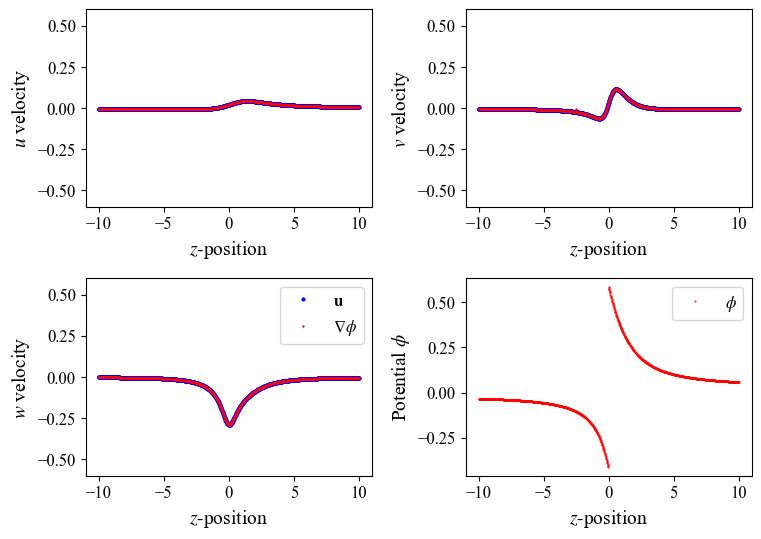

In [11]:
# Nodes of panels
nodes = [
             -2 -1 0;
             0  1 0;
             9999  1 0;
             9999  -1 0;
        ]'
nnodes = size(nodes, 2)
panel = collect(1:nnodes)

TE = collect(1:2)     # Indices of nodes that make the trailing edge
da = [1, 0, 0]        # Semi-infinite direction da
db = [1, 0.25, 0.5]   # Semi-infinite direction db
db /= pnl.norm(db)

# Translate and rotate panel
O = zeros(3)
Oaxis = pnl.gt.rotation_matrix(0, 0, 0)
# O = ones(3)
# Oaxis = pnl.gt.rotation_matrix(30, 40, 60)
# Oaxis = pnl.gt.rotation_matrix(30, 40, 60)

nodes = Oaxis'*nodes + repeat(O, 1, nnodes)
da = Oaxis'*da
db = Oaxis'*db

# Unitary panel's strength
strength = 1.0

cellcenter = Oaxis'*[2, -0.25, 0] + O
# cellcenter = Oaxis'*[0, 0, 0] + O
# normal = Oaxis'*[0, 0, -1]
normal = Oaxis'*[0, 0, 1]

# Define probe line
ntargets = 1001
Xoff = 0.25*[1, 1, 0]*0
# tilt = pnl.gt.rotation_matrix(30, 0, 0)
tilt = pnl.gt.rotation_matrix(0, 0, 0)
zs = range(-10, 10, length=ntargets)
Xs = [(cellcenter + Xoff) + z*tilt'*normal for z in zs]

targets = hcat(Xs...)

# Compute analytical velocity
U_ana = zeros(3, ntargets)
pnl.U_semiinfinite_doublet(nodes, TE, da..., db..., strength, targets, U_ana; offset=0, cutoff=0)

# Compute potential field
phis = zeros(ntargets)
pnl.phi_semiinfinite_doublet(nodes, TE, da..., db..., strength, targets, phis)


# Compute gradient of potential field
function fwrap(X::Array{R, 1}) where {R}
    targs = reshape(X, 3, 1)
    phis = zeros(R, 1)
    pnl.phi_semiinfinite_doublet(nodes, TE, da..., db..., strength, targs, phis)
    return phis
end

function eval_Udiff(X)

    Nin = 3                        # Number of inputs
    Nout = 1                       # Number of outputs
    cfg = FD.JacobianConfig(nothing, X, FD.Chunk{Nin}())

    J = zeros(Nout, Nin)           # Stores the Jacobian here, J[i,j]=dfi/dxj
    FD.jacobian!(J, fwrap, X, cfg)
    Udiff = reshape(J, 3, 1)          # Velocity from automatic differentiation
    
    return Udiff
end

U_diff = hcat([eval_Udiff(X) for X in eachcol(targets)]...)


# Plot probed velocity and potential fields
fig = plt.figure(figsize=[7*2, 5*2]*5/9)
axs = fig.subplots(2, 2)
axs = [axs[j, i] for i in 1:size(axs, 1), j in 1:size(axs, 2)]

for (axi, ax) in enumerate(axs[1:3])
    ax.plot(zs, U_ana[axi, :], "ob", markersize=2, label=L"\mathbf{u}")
    ax.plot(zs, U_diff[axi, :], "*r", markersize=1, label=L"\nabla \phi")
    
    ax.set_xlabel(L"$z$-position")
    ax.set_ylabel([L"u", L"v", L"w"][axi]*" velocity")
    ax.set_ylim(0.6*[-1, 1])
    ax.set_yticks(-0.5:0.25:0.5)
end

axs[3].legend(loc="best", frameon=true)

ax = axs[4]
ax.plot(zs, phis, ".r", markersize=1, label=L"\phi")
ax.set_xlabel(L"$z$-position")
ax.set_ylabel(L"Potential $\phi$")
ax.legend(loc="best", frameon=true)

fig.tight_layout()

# Evaluate potential field at z=0 and z=inf
normal = Oaxis'*[0, 0, -1]
h = 1e-8
# targets = [0 0 0; 0 0 1e10; 0 0 h]'
# targets = Oaxis'*hcat(zeros(3), [0, 0, 1e10], [0, 0, h])'  + O
targets = hcat(0*normal, 1e10*normal, h*normal)
phis = zeros(3)
pnl.phi_semiinfinite_doublet(nodes, TE, da..., db..., strength, targets, phis)

phidz = phis[3]

# println("phi at z=inf:\t\t$(phis[2])")
# println("phi at z=0:\t\t$(phis[1])")
# println("phi at z=$(sign(h)==1 ? "+" : "-")0:\t\t$(phidz)")
# println("mu:\t\t\t$(strength)")
# println("phi($(sign(h)==1 ? "+" : "-")0) == $(sign(h)==1 ? "-" : "+")mu/2 ? \t$(abs(phidz + sign(h)*strength/2) < 1e-4)")

nothing

### Verification &ndash; Induced flow direction

In [12]:
save_path = "temps/"
file_name = "semiinfinitenonplanardoubletpanel04"

# Nodes of panels
nodes = Float64[
             -0.5 -1 0;
             0  1 0;
             0  1 0;
             0  -1 0;
        ]'
nnodes = size(nodes, 2)
panel = collect(1:nnodes)

TE = collect(1:2)     # Indices of nodes that make the trailing edge
da = [1, 0, 0]        # Semi-infinite direction da
db = [1, 0.1, 0.25]   # Semi-infinite direction db
db /= pnl.norm(db)

nodes[:, 3] += 3*db
nodes[:, 4] += 3*da

# Translate and rotate panel
O = zeros(3)
Oaxis = gt.rotation_matrix(0, 0, 0)
# O = ones(3)
# Oaxis = gt.rotation_matrix(30, 0, 0)
nodes = Oaxis'*nodes + repeat(O, 1, nnodes)

# Unitary panel's strength
strength = 1.0

# Defines a grid for proving the velocity
P_max = [1.5, 1.5, 0.5]                     # Upper bound
P_min = [-0.5, -1.5, -0.5]                  # Lower bound
NDIVS = 56*[2, 2, 1]                        # Divisions in each dimension                     
grid = gt.Grid(P_min, P_max, NDIVS)         # Grid

gt.lintransform!(grid, Oaxis, O)

# Targets where to prove the velocity
targets = grid.nodes
ntargets = size(targets, 2)

# Array where to store velocities
phis = zeros(ntargets)
Us = zeros(3, ntargets)

# Calculates velocities
pnl.phi_semiinfinite_doublet(nodes, TE, da..., db..., strength, targets, phis)
# pnl.U_semiinfinite_doublet(nodes, TE, da..., db..., strength, targets, Us; offset=2e-2, cutoff=1e-5)
pnl.U_semiinfinite_doublet(nodes, TE, da..., db..., strength, targets, Us; offset=1e-1, cutoff=1e-5)

# Saves velocities into the grid
gt.add_field(grid, "phi", "scalar", phis, "node")
gt.add_field(grid, "U", "vector", collect(eachcol(Us)), "node")

# Normal vector
normal = gt._calc_normal(collect(eachcol(nodes)))
cell_data = [Dict(  "field_name" => "normal",
                    "field_type" => "vector",
                    "field_data" => [normal])][1:-1]

point_data = [Dict( "field_name" => "index",
                    "field_type" => "scalar",
                    "field_data" => [i for i in 1:nnodes])]

str = save_path*"/"

line = [i-1 for i in 1:nnodes]
line = vcat(line[end], line[1:end-1])

# Outputs vtks
str *= gt.generateVTK(file_name*"_panel", collect(eachcol(nodes)); path=save_path, 
                        lines=[line], cell_data=cell_data, point_data=point_data)
str *= gt.save(grid, file_name*"_grid"; path=save_path)

# Open vtks
run(`paraview --data=$str`)

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


VisRTX 0.1.6, using devices:
 0: NVIDIA RTX A3000 Laptop GPU (Total: 6.2 GB, Available: 6.1 GB)


Process(`paraview '--data=temps//semiinfinitenonplanardoubletpanel04_panel.vtk;semiinfinitenonplanardoubletpanel04_grid.xmf;'`, ProcessExited(0))

# Body Definition

In this section we describe and exemplify the different approaches for generating paneled surfaces.

## `AbstractBody`

`AbstractBody` defines the abstract type on which all Body implementations extend. It is defined as follows:

In [13]:
? FLOWPanel.AbstractBody

Abstract type `AbstractBody{N, E<:AbstractElement}` where `N` is the number of element types in this body and `E` is an Union containing the `N` element types.

Implementations of AbstractBody are expected to have the following fields

  * `grid::GeometricTools.GridTriangleSurface`     : Paneled geometry
  * `nnodes::Int`                       : Number of nodes
  * `ncells::Int`                       : Number of cells
  * `fields::Array{String, 1}`          : Available fields (solutions)
  * `Oaxis::Matrix`                     : Coordinate system of original grid (3x3 matrix)
  * `O::Vector`                         : Position of CS of original grid (3-dim vector)
  * `strength::Matrix`                  : Strength of each element of each type (ncells x N matrix)
  * `CPoffset::Real`                    : Control point offset in normal direction
  * `characteristiclength::Function`    : Function for computing the characteristic                                       length of each panel used to offset each                                       control point
  * `kerneloffset::Real`                : Kernel offset to avoid singularities
  * `kernelcutoff::Real`                : Kernel cutoff to avoid singularities

and the following functions

```julia

    # Imposes boundary conditions to solve for element strengths.
    function solve(self::AbstractBody, Uinfs::Array{<:Real, 2}, args...)
        .
        .
        .
    end

    # Outputs the body as a vtk file
    function save(self::AbstractBody, args...; optargs...)
        .
        .
        .
    end

    # Returns the dimensions of the system of equations solved by `solve(...)`
    # as a tuple `(m, n)`, where `m` is the number of equations and `n` is the
    # number of unknowns (usually `m==n`).
    function _get_Gdims(self::AbstractBody)
        .
        .
        .
    end

    # Returns the velocity induced by the body on the targets `targets`. It adds
    # the velocity at the i-th target to out[:, i].
    function _Uind(self::AbstractBody, targets::Array{<:Real, 2},
                    out::Array{<:Real, 2}, args...; optargs...)
        .
        .
        .
    end

    # Returns the potential induced by the body on the targets `targets`. It
    # adds the potential at the i-th target to out[i].
    function _phi(self::AbstractBody, targets::Array{<:Real, 2},
                    out::Array{<:Real, 1}, args...; optargs...)
        .
        .
        .
    end
```


It is recommended that wings follow conventional aerodynamic coordinates, building the wing from left tip ($-y$) to right tip ($+y$), leading edge pointing in the direction of $-x$ and trailing edge in the direction of $+x$, and top side of the airfoil in the direction of $+z$. However, the user is free to define wings in any arbitrary convention since the solvers are indifferent to orientation. Unless otherwise indicated, the solvers are indifferent to whether normals point inside or outside the geometry, but for consistency, it is good practice to define the geometry such as to have the normals pointing outside. This is done by building every airfoil **starting at the trailing edge first going around the bottom side towards the leading edge, and going back to the trailing edge around the top side**. The following figure shows the node indexing (green) and cell indexing (pink) of the left tip in a wing defined as explained above:

<img src="img/paneledwing00.png" alt="Pic here" style="width: 800px;"/>

The following functions are automatically provided for any implementation of `AbstractBody`:

In [14]:
? FLOWPanel.Uind!

```
Uind!(self::AbstractBody, targets, out, args...; optargs...)
```

Returns the velocity induced by the body on the targets `targets`, which is a 3xn matrix. It adds the velocity at the i-th target to `out[:, i]`.


In [15]:
? FLOWPanel.phi!

```
phi!(self::AbstractBody, targets, out, args...; optargs...)
```

Returns the potential induced by the body on the targets `targets`. It adds the potential at the i-th target to `out[:, i]`.


In [16]:
? FLOWPanel.get_ndivscells

```
get_ndivscells(body::AbstractBody)
```

Returns a tuple with the number of cells in each parametric dimension


In [17]:
? FLOWPanel.get_ndivsnodes

```
get_ndivsnodes(body::AbstractBody)
```

Returns a tuple with the number of nodes in each parametric dimension


In [18]:
? FLOWPanel.get_cart2lin_cells

```
get_cart2lin_cells(self::AbstractBody)
```

Returns a `LinearIndices` that converts the coordinates (or "Cartesian index") of a cell to its linear index.

!!! tip "Example"



```julia
    coordinates = (i, j)                # (i, j) coordinates of an arbitrary cell

    cart2lin = get_cart2lin_cells(body)

    index = cart2lin(coordinates...)    # Linear index of the cell
```


In [19]:
? FLOWPanel.get_cart2lin_cells

```
get_cart2lin_cells(self::AbstractBody)
```

Returns a `LinearIndices` that converts the coordinates (or "Cartesian index") of a cell to its linear index.

!!! tip "Example"



```julia
    coordinates = (i, j)                # (i, j) coordinates of an arbitrary cell

    cart2lin = get_cart2lin_cells(body)

    index = cart2lin(coordinates...)    # Linear index of the cell
```


In [20]:
? FLOWPanel.get_cart2lin_nodes

```
get_cart2lin_nodes(self::AbstractBody)
```

Returns a `LinearIndices` that converts the coordinates (or "Cartesian index") of a node to its linear index.

!!! tip "Example"



```julia
    coordinates = (i, j)                # (i, j) coordinates of an arbitrary node

    cart2lin = get_cart2lin_nodes(body)

    index = cart2lin(coordinates...)    # Linear index of the node
```


In [21]:
? FLOWPanel.get_field

```
get_field(self::AbstractBody, field_name::String)
```

Returns the requested field.


In [22]:
? FLOWPanel.get_fieldval

```
get_field(self::AbstractBody, field_name::String, i::Int)
```

Returns the requested field value of the i-th cell or node (depending of the field type). Give it `_check=false` to skip checking logic for faster processing.

---

```
get_fieldval(self::AbstractBody, field_name::String, coor::Array{Int,1})
```

Returns the requested field value of the cell or node (depending of the field type) of coordinates `coor` (1-indexed).


In [23]:
? FLOWPanel.add_field

```
add_field(self::AbstractBody, field_name::String, field_type::String,
                                            field_data, entry_type::String)
```

Adds a new field `field_name` to the body (overwriting the field if it already existed).

**Expected arguments**

  * `field_type=="scalar"`, then `field_data` is a vector of length `n`.
  * `field_type=="vector"`, then `field_data` is an array of 3-dim vectors of   length `n`.
  * `entry_type=="node"`, then `n=length(field_data)` is the number of nodes in   the body and `field_data[i]` is the field value at the i-th node.
  * `entry_type=="cell"`, then `n=length(field_data)` is the number of cells in   the body and `field_data[i]` is the field value at the i-th cell.
  * `entry_type=="system"`, then `n=length(field_data)` is any arbritrary number,   and `field_data` is a field for the whole body as a system without any   data structure.


In [24]:
? FLOWPanel.calc_normals!

```
calc_normals!(body::AbstractBody, normals::Matrix)
```

Calculates the normal vector of every cell in `body` and stores them in the 3xN matrix `normals`.

**Output:** `normals[:, i]` is the normal vector of the i-th cell (linearly indexed).

!!! tip "Tip: Cartesian to linear indices"
    Normals can be accessed through their (i, j) coordinates (or "Cartesian indices") as follows:

    ```julia
        coordinates = (i, j)

        ndivscells = get_ndivscells(body)
        lin = LinearIndices(Tuple(ndivscells))
    ```



In [25]:
? FLOWPanel.calc_normals

```
calc_normals(self::AbstractBody)
```

Calculates the normal vector of every cell in `grid` returning a 3xN matrix.

See `calc_normals!` documentation for more details.


In [26]:
? FLOWPanel.calc_controlpoints!

```
calc_controlpoints!(body::AbstractBody, controlpoints::Matrix, normals::Matrix)
```

Calculates the control point of every cell in `body` and stores them in the 3xN matrix `controlpoints`. It uses `body.CPoffset`, `body.charateristiclength`, and `normals` to offset the control points off the surface in the normal direction.

**Output:** `controlpoints[:, i]` is the control point of the i-th cell (linearly indexed).

!!! tip
    Use `normals = calc_normals(body)` to calculate the normals.



In [27]:
? FLOWPanel.calc_controlpoints

```
calc_controlpoints(body::AbstractBody)
```

Calculates the control point of every cell in `body` returning a 3xN matrix.

See `calc_controlpoints!` documentation for more details.


# Geometry

Some of the solvers implemented in FLOWPanel require flat panels and a structured surface grid that facilitates the declaration of edges along which to specify the Kutta condition. 
Hence, all paneled bodies are required to be structured grids. 

The package [`GeometricTools.jl`](https://github.com/byuflowlab/GeometricTools.jl) implements a variety of methods for the generation of grids and meshes, refinement, and space transformations, and is chosen as the geometric engine for FLOWPanel. Here below we show the low level manipulation of `GeometricTools.jl` for the sake of showing how to manually define complex geometries based on space transformations and localized refinement. The section *Body Definition* shows predefined methods for creating common geometries, *e.g.*, lofted surfaces, surfaces of revolution, etc.

## Cartesian Grid

The object `Grid` defines a structured cartesian $n$-dimensional grid and it is the base for all other types of grids. Here below is the object constructor and associated functions. For examples see [the documentation of GeometricTools](https://nbviewer.jupyter.org/github/byuflowlab/GeometricTools.jl/blob/master/docs/Documentation.ipynb).

In [28]:
? gt.Grid

`Grid(P_min, P_max, NDIVS)`

Generates an n-dimensional grid.

**Arguments**

  * `P_min::Array{Float64,1}`   : Minimum point of the domain.
  * `P_max::Array{Float64,1}`   : Maximum point of the domain.
  * `NDIVS::Array{Int64,1}`     : Number of divisions in each coordinate.

**Properties**

  * `dims::Int64`               : Number of dimensions.
  * `nnodes::Int64`             : Number of nodes in the grid.
  * `nodes::Array{Float64,2}`   : Matrix size (`nnodes`, `dims`) of node position.
  * `field` : Contains calculated fields formated as field[field*name] = Dict(                         "field*name" => field*name::String,                         "field*type" => "scalar" or "vector",                         "entry*type" => "node" or "cell",                         "field*data" => data                         )         where `data` is an array data[i] = [val1, val2, ...] containing         this field values (scalar or vector) at each node in the grid.

NOTE: All indexing is done linearly, meaning that `nodes` is indexed from 1 to       `nnodes`, and all data fields follow the same indexing.

NOTE2: `NDIVS` can either be an array of integers with NDIVS[i] indicating the       number of divisions in the i-th coordinate, or it can be an array of       sections (see `multidiscretize()` doc) with NDIVS[i] = [sec1, sec2, ...]       indicating the discretization into sections in the i-th coordinate.


In [29]:
? gt.get_node

`get_node(grid, i)`

Returns the position of the i-th node (1-indexed) in the grid

---

`get_node(grid, coor)`

Returns the position of the node of subscript coordinates `coor` (1-indexed)


In [30]:
? gt.get_cell

`get_cell(grid, i)`

Returns the nodes indices of i-th cell in the grid (1-indexed)

---

`get_cell(grid, coor)`

Returns the node indices of the cell with subscript coordinates `coor` (1-indexed). The format corresponds to VTK*HEXAHEDRON (=12) in 3D, VTK*QUAD (=9) in 2D, or VTK_LINE (=3) in 1D–-except that points are 1-indexed instead of 0-indexed.


<table style="width:100%">
  <tr>
    <td>
        <img src="img/vtk00.png" alt="Pic here" style="width: 200px;"/>
    </td>
    <td>
        <img src="img/vtk01.png" alt="Pic here" style="width: 150px;"/>
    </td>
    <td>
        <img src="img/vtk02.png" alt="Pic here" style="width: 200px;"/>
    </td>
  </tr>
</table>

In [31]:
? gt.add_field

`add_field(grid::Grid, field_name::String, field_type::String, field_data, entry_type::String)`

Adds a field of data associated to each node.

NOTE: each data entry must be a single value if `field_type==scalar`, or a       3-element array if `field_type==vector`.


In [32]:
? gt.calculate_field

`calculate_field(grid::Grid, f, field_name::String, field_type::String)`

Evaluates the function `f` at each nodes and stores the values as a new field.

NOTE: f must return a single value if `field_type==scalar`, or a 3-element array       if `field_type==vector`.


In [33]:
? gt.get_fieldval

`get_fieldval(grid, field_name, coor)`

Returns the value of node of coordinates `coor` (1-indexed) in the field 'field_name'.

---

`get_fieldval(grid, field_name, i)`

Returns the value of i-th node (1-indexed) in the field 'field_name'.


## Space Transformations

A Cartesian grid can be used as the starting point to define a more complex structured grid through any arbitrary non-linear transformation:

In [34]:
? gt.transform!

`transform!(grid::Grid, f)`

Applies the space transformation given by function `f` to the grid, where the position of every node is given to the function `f`.


GeometricTools also provides the following function for a linear transformation (rotation and translation):

In [35]:
? gt.lintransform!

`lintransform!(grid::Grid, M::Array{Float64,2}, T::Array{Float64,1})`

Rotates and translates the grid by the rotation matrix `M` and translation vector `T` (linear transformation).


GeometricTools provides the following non-linear [orthogonal space transformations](https://en.wikipedia.org/wiki/Orthogonal_coordinates): `cylindrical3D(X)`, `cylindrical2D(X)`, `spherical3D(X)`, `parabolic3D(X)`, `paraboloidal3D(X)`, `elliptic3D(X; a=1)`, `prolate3D(X; a=1)`, `oblate3D(X; a=1)`, `bipolar3D(X; a=1)`, `toroidal3D(X; a=1)`, and `conical3D(X; b=2, c=1)`. 

For linear transformations, `rotation_matrix(yaw::Real, pitch::Real, roll::Real)` returns the rotation matrix of such angles, and `axis_rotation(r::Array{Float64, 1}, angle_deg::Float64)` returns the transformation matrix of rotation around an arbitrary axis of unit vector `r`.

The user can also define an arbitrary space transformation. The airfoil example in the Looped Grid section shows the example of transforming a quasi-one-dimensional line into an two-dimensional airfoil contour.

## Example &mdash; 2D Circular Grid

To demonstrate the use of space transformations, in this example we generate a two-dimensional circular grid.
First we define the boundaries of the circular section $r_\text{min}, r_\text{max}, \theta_\text{min}, \theta_\text{max}$ as a cartesian grid of minimum and maximum bounds $P_\text{min}=(r_\text{min}, \theta_\text{min})$ and $P_\text{max}=(r_\text{max}, \theta_\text{max})$, respectively.
We then applying a cylindrical transformation on the grid. 
The cylindrical transformation takes the current $x,y$ coordinates of the grid as $r,\theta$ for the new grid. In this case, $r_\text{min}=R/4$, $r_\text{max}=R$, $\theta_\text{min}=0^\circ$, $\theta_\text{max}=270^\circ$, as shown below.

<img src="img/circ01.png" alt="Pic here" style="width: 600px;"/>

In [36]:
file_name = "circulargrid00"                # Output file
paraview = true                             # Whether to visualize the grid in Paraview

R = 1.0                   # Radius of circle

P_min = [R/4, 0*pi/180]   # Lower boundaries r, theta
P_max = [R, 270*pi/180]   # Upper boundaries r, theta

NDIVS = [15, 60]          # 15 radius divisions, 60 angle divisions

# Generate the Cartesian grid
grid = gt.Grid(P_min, P_max, NDIVS)

# Convert grid to cylindrical
gt.transform!(grid, gt.cylindrical2D)

# Visualization
if paraview
    
    # Output a vtk file
    gt.save(grid, file_name; format="vtk")

    # Call paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
    
else
    # Use PyPlot instead of Paraview
    gt.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true)
end;

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


VisRTX 0.1.6, using devices:
 0: NVIDIA RTX A3000 Laptop GPU (Total: 6.2 GB, Available: 6.1 GB)


Notice that `NDIVS` can still be used to defined sections of refinement:

<img src="img/circ02.png" alt="Pic here" style="width: 600px;"/>

In [37]:
file_name = "circulargrid01"                # Output file
paraview = true                             # Whether to visualize the grid in Paraview

NDIVS = [   # r sections
            [(1.0, 15, 5.0, true)],
            # theta sections
            [(1/3, 15, 1/3, false),
             (1/3, 15, 3.0, true),
             (1/3, 15, 3.0, false)]
        ]

# Generates the grid as cartesian
grid = gt.Grid(P_min, P_max, NDIVS)

# Converts to cylindrical
gt.transform!(grid, gt.cylindrical2D)

# Visualization
if paraview
    
    # Outputs a vtk file
    gt.save(grid, file_name; format="vtk")

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
else
    # Use PyPlot instead of Paraview
    gt.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true)
end;

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


VisRTX 0.1.6, using devices:
 0: NVIDIA RTX A3000 Laptop GPU (Total: 6.2 GB, Available: 6.1 GB)


## Looped Grid

For some applications it is convenient to define a grid that loops on itself, making the last cell in a dimension close back with the first cell. The `Grid` object accepts an optional argument indicating the dimension that loops on itself as follows:

`Grid(P_min, P_max, NDIVS, loop_dim)`

where `loop_dim` is an integer indicating the dimension to loop.


Here is an example of a cylindrical grid $(r, \theta)$ where the nodes at $\theta=0^\circ$ and $\theta=360^\circ$ end up overlapping (notice nodes 1, 2, and 3 overlapping with 16, 17, and 18).

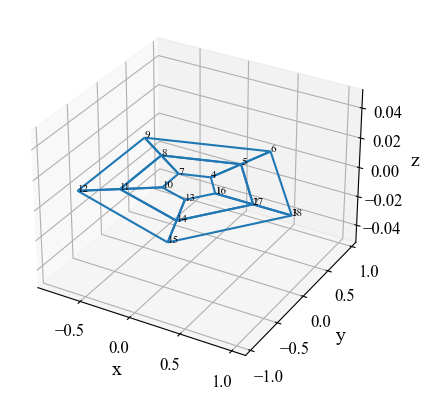

In [38]:
R = 1.0                   # Radius of circle

P_min = [R/4, 0*pi/180]   # Lower boundaries r, theta
P_max = [R, 360*pi/180]   # Upper boundaries r, theta

NDIVS = [2, 5]          # 15 radius divisions, 60 angle divisions

# Generates the grid as cartesian
grid = gt.Grid(P_min, P_max, NDIVS)

# Converts to cylindrical
gt.transform!(grid, gt.cylindrical2D)

gt.plot(grid; labelnodes=true, labelcells=!true, labelndivs=!true, fontsize=8);

Using `loop_dim=2`, now the $\theta$-coordinate loops on itself, merging the nodes that were overlapping:

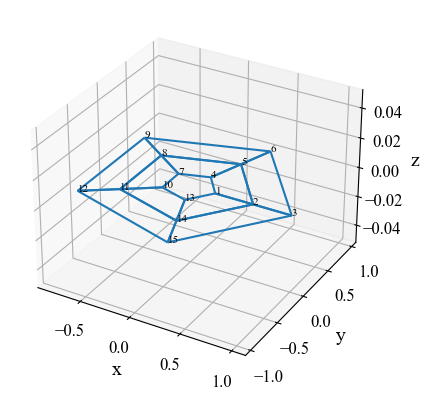

In [39]:
loop_dim = 2              # Loop the theta dimension

# Generates the grid as cartesian
grid = gt.Grid(P_min, P_max, NDIVS, loop_dim)

# Converts to cylindrical
gt.transform!(grid, gt.cylindrical2D)

gt.plot(grid; labelnodes=true, labelcells=!true, labelndivs=!true, fontsize=8);

## Example &mdash; Airfoil Contour

We will now both a space transformation and a looped grid to generate a two-dimensional airfoil section. The airfoil section is generated through the following procedure:

1. Read a collection of points from a CSV file describing an airfoil contour ("Original Airfoil Geometry").
2. Split the contour into upper and lower surfaces.
3. Spline through the points generating two analytic curve parameterized from inputs 0 to 1.
4. Generate a 1D line that represents a structured grid ("Original Grid").
5. Apply a space transformation to the 1D line to curve it into the shape of the airfoil contours ("Transformed Grid").

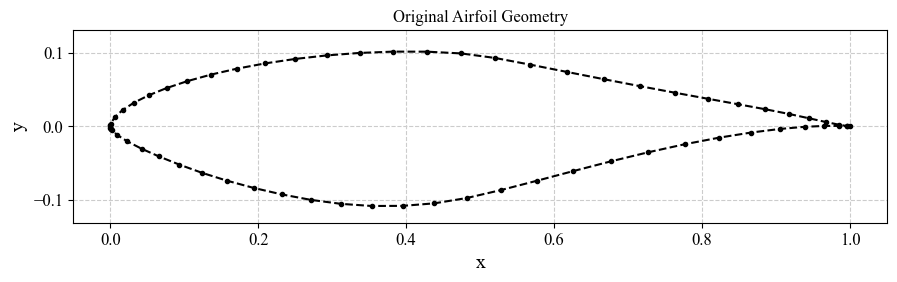

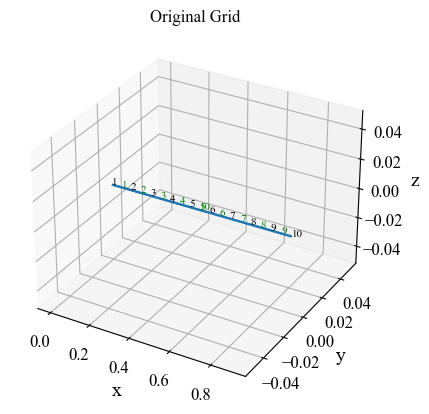

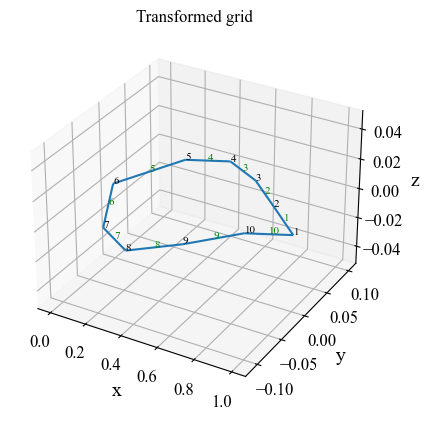

In [40]:
# ----------------- READ AND PARAMETERIZE AIRFOIL -----------------------------
# Read airfoil contour
x,y = gt.readcontour(joinpath(airfoil_path, "S809.txt"); header_len=2)

gt.plot_airfoil(x,y; style="--.k", title_str="Original Airfoil Geometry")

# Separate upper and lower surfaces to make the contour injective in x
upper, lower = gt.splitcontour(x,y)

# Parameterize both surfaces independently
fun_upper = gt.parameterize(upper[1], upper[2], zeros(size(upper[1])); inj_var=1, s=1e-6)
fun_lower = gt.parameterize(lower[1], lower[2], zeros(size(lower[1])); inj_var=1, s=1e-6)



# ----------------- CREATE GRID OF AIRFOIL CONTOUR ----------------------------
# Create the grid as a quasi-1D line
#   `X[1]` is the arc-length around the airfoil contour (between 0 and 1),
#   `X[2]` is a dummy value.

P_min = [0, 0]             # Lower boundaries of arclength and dummy
P_max = [1, 0]             # Upper boundaries of arclength and dummy 
NDIVS = [10, 0]            # 100 arclength divisions, 0 dummys  divisions
loop_dim = 1               # Loop the arclength dimension

grid = gt.Grid(P_min, P_max, NDIVS, loop_dim)

gt.plot(grid; labelnodes=true, labelcells=true, labelndivs=!true, 
                fontsize=8, fig_name="org", title_str="Original Grid")


# Create space transformation function
function my_space_transform(X)
    if X[1]<0.5
        return fun_upper(1-2*X[1])[1:2]
    else
        return fun_lower(2*(X[1]-0.5))[1:2]
    end
end

# Transforms the quasi-1D line into the 2D airfoil contour
gt.transform!(grid, my_space_transform)

gt.plot(grid; labelnodes=true, labelcells=true, labelndivs=!true, 
                fontsize=8, title_str="Transformed grid");


## Surface Grid and "Quasi-Dimensions"

A 3D surface grid can be generated by defining a 3D grid where one of its dimensions has zero divisions, and then transforming the space into the surface geometry. A dimension with zero divisions is recognized as a "quasi-dimension", which is a place holder for space transformations without actually spanning the dimensions of the grid. For instance, a 3D grid with one quasi-dimension doesn't define its cells as VTK_HEXAHEDRONs as a regular 3D grid would, but **its cells are defined as VTK_QUADs**. Also, quasi-dimensions are not considered as a coordinate direction, meaning that a node/cell in a 3D grid with one quasi-dimension is not indexed by three coordinates $(i,j,k)$, but with **only two coordinates $(i,j)$**.

The following lines exemplify the process of defining the quasi-dimensional grid, and applying the space transformation:

```julia
# Create quasi-3D grid
P_min = [0, -1, 0]            # Lower boundaries of arclength, span, and dummy
P_max = [1, 1, 0 ]            # Upper boundaries of arclength, span, and dummy
NDIVS = [20, 10, 0]           # Divisions: 20 arclength, 10 span, 0 dummy
grid = gt.Grid(P_min, P_max, NDIVS)


# Create a space transformation function
function my_space_transform(X)
    new_X = # Write a new definition of each node here
    return new_X
end

# Applie the space transformation
gt.transform!(grid, my_space_transform)
```

## Example &mdash; Paneled Wing

We will now use a space transformation on a 2D looped grid with 3D quasi-dimensions to generate the 3D surface of a wing.

<img src="img/wing04.png" alt="Pic here" style="width: 800px;"/>
<img src="http://edoalvar2.groups.et.byu.net/public/FLOWPanel/wing04.gif" alt="Vid here" style="width: 800px;"/>

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


VisRTX 0.1.6, using devices:
 0: NVIDIA RTX A3000 Laptop GPU (Total: 6.2 GB, Available: 6.1 GB)


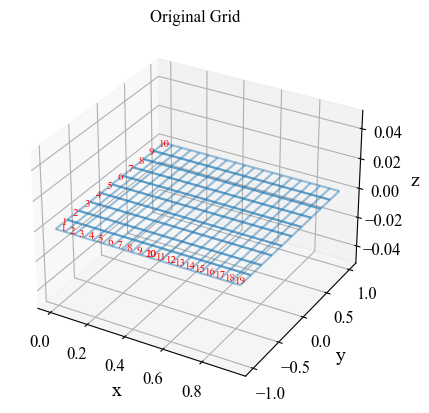

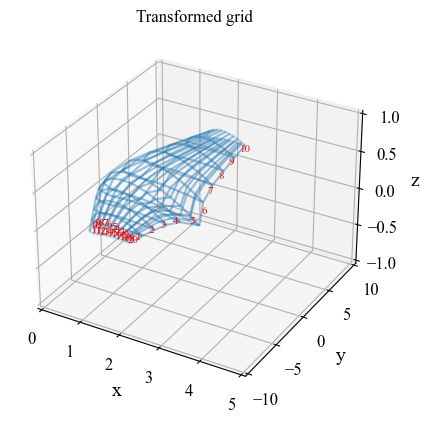

In [41]:
file_name = "paneledwing00"
paraview = true

# ----------------- READ AND PARAMETERIZE AIRFOILS ----------------------------
semispan = 10            # (m) semi-span length

chords = [(0, 2.5),      # (semi-span position, chord length (m))
          (0.25, 2.0),
          (1, 1.0)]

x_pos = [(0, 0),         # (semi-span position, leading edge x-position (m))
         (0.25, semispan/40 ),
         (1, semispan/8 )]

z_pos = [(0, 0),         # (semi-span position, leading edge z-position (m))
         (0.25, semispan/100 ),
         (1, semispan/50 )]

twist = [(0, 5),         # (semi-span position, twist (deg))
         (1, 0)]

airfoils = [(0, "naca6412.dat"), # (semi-span position, airfoil geometry)
            (1, "naca6412.dat")]

airfoil_funs = []

for (pos, airfoil_file) in airfoils
    # Read the original airfoil geometry from airfoiltools.com
    org_x, org_y = gt.readcontour(joinpath(airfoil_path, airfoil_file); header_len=1)

    # Separate upper and lower sides to make the contour injective in x
    upper, lower = gt.splitcontour(org_x, org_y)

    # Parameterize both sides independently
    fun_upper = gt.parameterize(upper[1], upper[2], zeros(size(upper[1])); inj_var=1)
    fun_lower = gt.parameterize(lower[1], lower[2], zeros(size(lower[1])); inj_var=1)
    
    push!(airfoil_funs, [pos, (fun_upper, fun_lower)])
end


# ----------------- CREATE 3D SURFACE GRID ----------------------------------
P_min = [0, -1, 0]            # Lower boundaries arclength, span, dummy
P_max = [1, 1, 0 ]            # Upper boundaries arclength, span, dummy
NDIVS = [20, 10, 0]           # 50 arclength cells, 10 span cells, 0 dummy
loop_dim = 1                  # Loop the arclength dimension

grid = gt.Grid(P_min, P_max, NDIVS, loop_dim)

gt.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true, 
                fontsize=8, fig_name="org", title_str="Original Grid", 
                alpha=0.25)


# Auxiliary function for weighting values across span
function calc_vals(span, array)
    
    # Finds bounding airfoil position
    val_in, val_out = nothing, array[1]
    for val in array[2:end]
        val_in = val_out
        val_out = val
        if val[1]>=abs(span); break; end
    end 
    pos_in = val_in[1]
    val_in = val_in[2]
    pos_out = val_out[1]
    val_out = val_out[2]
    
    weight = (abs(span)-pos_in)/(pos_out-pos_in)
            
    return weight, val_in, val_out
end

# Creates a space transformation function
function my_space_transform(X)
    span = X[2]
    
    # Calculates chord
    weight, chord_in, chord_out = calc_vals(span, chords)
    chord = weight*chord_out+(1-weight)*chord_in
    
    # Calculates airfoil geometry
    weight, rfl_in, rfl_out = calc_vals(span, airfoil_funs)
    fun_upper_in, fun_lower_in = rfl_in
    fun_upper_out, fun_lower_out = rfl_out
    
    # Arc-length on upper or lower side of airfoil
    if X[1]<0.5
        s = 1 - 2 * X[1]
        fun_in = fun_upper_in
        fun_out = fun_upper_out
    else
        s = 2 * (X[1] - 0.5)
        fun_in = fun_lower_in
        fun_out = fun_lower_out
    end
    
    # Point over airfoil contour
    point =  weight * fun_out(s) + (1 - weight) * fun_in(s)
    point = chord * point
    
    # Twist
    weight, twist_in, twist_out = calc_vals(span, twist)
    this_twist = weight * twist_out + (1 - weight) * twist_in
    
    # Applies twist to the airfoil point
    point = gt.rotation_matrix(-this_twist, 0, 0) * point
    
    # Leading edge x-position
    weight, x_in, x_out = calc_vals(span, x_pos)
    le_x = weight * x_out + (1 - weight) * x_in
    
    # Leading edge z-position
    weight, z_in, z_out = calc_vals(span, z_pos)
    le_z = weight * z_out + (1 - weight) * z_in
    
    # Span position
    y = X[2] * semispan
    
    return [point[1] + le_x, y, point[2] + le_z]
end

# Transforms the quasi-2D grid into the wing surface
gt.transform!(grid, my_space_transform)


lims = [-semispan, semispan]
gt.plot(grid; labelnodes=!true, labelcells=!true, labelndivs=true, 
                fontsize=8, title_str="Transformed grid", alpha=0.25,
                xlims=lims / 2 .* [0,1], ylims=lims, zlims=lims/10);

# Adds some dummy example fields
gt.add_field(grid, "node_index", "scalar", [i for i in 1:grid.nnodes], "node")
gt.add_field(grid, "cell_index", "scalar", [i for i in 1:grid.ncells], "cell")

if paraview
    # Outputs a vtk file
    gt.save(grid, file_name; format="vtk")

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
end;

By construction, the wing we have defined has non-planar quadrilateral panel. Since some solvers require planar panels, GeometricTools has a especial type of grid that receives a 3D surface `Grid` object, and splits all non-planar quadrilateral panels into planar triangular panels of the `VTK_TRIANGLE` type.

<img src="img/vtk_triangle.png" alt="Pic here" style="width: 200px;"/>

This is implemented in the `GridTriangleSurface` type:

In [42]:
? gt.GridTriangleSurface

`GridTriangleSurface(orggrid, dimsplit)`

Receives a 3D surface grid (like the one in `Paneled Wing Example` in the documentation), which by construction is made of nonplanar quadrilateral panels, and creates a surface grid of planar triangular panels by splitting every original quadrilateral panel into triangles.

**Arguments**

  * `orggrid`         : Original quadrilateral surface grid.
  * `dimsplit`        : Dimension along which to split the quadrilaterals.


In [43]:
file_name = "paneledwing01"

# Splits the quadrialateral panels into triangles
dimsplit = 1              # Dimension along which to split
triang_grid = gt.GridTriangleSurface(grid, dimsplit)

# Adds some dummy example fields
gt.add_field(triang_grid, "node_index", "scalar", 
                    [i for i in 1:triang_grid.nnodes], "node")
gt.add_field(triang_grid, "cell_index", "scalar", 
                    [i for i in 1:triang_grid.ncells], "cell")
gt.add_field(triang_grid, "normal", "vector", 
                    [gt.get_normal(triang_grid, i) 
                       for i in 1:triang_grid.ncells], "cell")
gt.add_field(triang_grid, "tangent", "vector", 
                    [gt.get_tangent(triang_grid, i) 
                       for i in 1:triang_grid.ncells], "cell")

if paraview
    # Outputs a vtk file
    gt.save(triang_grid, file_name; format="vtk")

    # Calls paraview
    run(`paraview --data=$file_name.vtk`)

    # Delete vtk file
    run(`rm -f $file_name.vtk`)
end
nothing

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


VisRTX 0.1.6, using devices:
 0: NVIDIA RTX A3000 Laptop GPU (Total: 6.2 GB, Available: 6.1 GB)


<img src="img/wing05.png" alt="Pic here" style="width: 800px;"/>

## Automatic Geometry Generation

Using the concepts of quasi-dimensions, looped grids, and space transformations, GeometricTools can automatically generate the geometry of lofted bodies and bodies of revolution through the functions listed below (see Section "Body Definition" for examples on how to use these functions).

In [44]:
? gt.generate_loft

`generate_loft(crosssections, bscale, b_pos, chords, twists, LE_x, LE_z)`

Generates a lofted surface geometry. The name of the arguments are taken from   its initial application to the lofting of an aircraft wing, so bear with it.

**Arguments**

  * `bscale::Float64`         : Semi-span scale. It will scale the entire                             geometry by this factor.
  * `b_pos::Array{Float64, 1}`: Normalized span positions y/bscale of the                             following distributions.
  * `chords::Array{Float64,1}`: Chord c/bscale distribution.
  * `twists::Array{Float64,1}`: Twist (deg) distribution.
  * `LE_x::Array{Float64,1}`  : x-position (chordwise) x/bscale of leading edge                             distribution.
  * `LE_z::Array{Float64,1}`  : z-position (dihedral-wise) z/bscale of leading                             edge distribution.
  * `crosssections::Array{Tuple{T,Array{T,2}}, 1}`    : cross sections along the                             span in the form [(y/bscale, crosssection)],                             where `crosssection` is a matrix that contains                             all points of the airfoil contour indexed by                             row. In order to define the resulting normals                             pointing out of the geometry, the points in                             `crosssection` must start from the trailing                             edge, go around the top side towards the leading                             edge, and back to the trailing edge around the                             bottom side. ALL CROSS SECTIONS MUST HAVE THE                             SAME NUMBER OF POINTS.

**Optional Arguments**

  * `tilt_z::Array{Float64,1}`: Tilting (deg) about the z-axis of every span                             cross section. This is also a distribution.
  * `symmetric::Bool`         : Whether to consider the `crosssections` to be                             symmetric about the semi-span. If true, only                             positive y/bscale are neeeded.

NOTE: The resulting geometry will be a structured surface mesh with the first   index going in chordwise direction starting from the TE around the bottom   surface and around back to the TE. The second index is the in the spanwise   direction starting at left end (lowest position along y axis) to right end.

---

`generate_loft(crosssections, bscale, b_low, b_up, b_NDIVS, chords, twists, LE_x, LE_z; optargs...)`

Generates a lofted surface geometry. The name of the arguments are taken from   its initial application to the lofting of an aircraft wing, so bear with it.

**Arguments**

  * `bscale::Float64`         : Semi-span scale. It will scale the entire                             geometry by this factor. All y/bscale values in                             the following arguments must go from 0 to 1.
  * `b_low::Float64`          : Scaled lower bound of the span.
  * `b_up::Float64`           : Scaled upper bound of the span. To generate                             a symmetric wing, give it b*low=-1, b*up=1 and .                             symmetric=true; for a semi-span, give it                             b*low=0, b*up=1. If generating a prop blade,                             give it b*low=Rhub/Rtip, b*up=1.
  * `b_NDIVS`                 : Number of divisions (cells) along span. This                             if either an Int or an array of sections in the                             format of `multidiscretize()`.
  * `chords::Array{Float64,2}`: Chord distribution along the span in the form                             [y/bscale c/bscale].
  * `twists::Array{Float64,2}`: Twist distribution along the span in the form                             [y/bscale deg].
  * `LE_x::Array{Float64,2}`  : x-position (chordwise) of leading edge along the                             span in the form [y/bscale x/bscale].
  * `LE_z::Array{Float64,2}`  : z-position (dihedral-wise) of leading edge along                             the span in the form [y/bscale z/bscale].
  * `crosssections::Array{Tuple{T,Array{T,2}}, 1}`    : cross sections along the                             span in the form [(y/bscale, crosssection)],                             where `crosssection` is a matrix that contains                             all points of the airfoil contour indexed by                             row. In order to define the resulting normals                             pointing out of the geometry, the points in                             `crosssection` must start from the trailing                             edge, go around the top side towards the leading                             edge, and back to the trailing edge around the                             bottom side. ALL CROSS SECTIONS MUST HAVE THE                             SAME NUMBER OF POINTS.

**Optional Arguments**

  * `tilt_z::Array{Float64,2}`: Tilting about the z-axis of every span cross                             section in the form [(y/bscale, deg)].
  * `spl_k`, `spl_bc`, `spl_s`: Spline parameters with k the degree of the                             spline, bc the boundary condition, and s the                             smoothing or error of the spline.

NOTE: The resulting geometry will be a structured surface mesh with the first   index going in chordwise direction starting from the TE around the bottom   surface and around back to the TE. The second index is the in the spanwise   direction starting at left end (lowest position along y axis) to right end.

---

`generate_loft(crosssections, upper_rfl_NDIVS, lower_rfl_NDIVS, args...; rflspl_k::Int64=5, rflspl_s::Real=0.001, verify_rflspline::Bool=true, rfloptargs=[], optargs...)`

This function also rediscretizes the cross sections as indicated by   `upper_rfl_NDIVS`, and `lower_rfl_NDIVS` (upper and lower surface sections,   respectively). Hence, the original cross sections need not to have the same   number of points.

---

`generate_loft(crosssections::Array{Tuple{T,String}, 1},                         data_path::String, args...; header_len::Int64=1,                         delim::String=" ", optargs...) where{T<:Real}`

Loft a geometry where the cross sections are read from the files indicated by `crosssections` found in `data_path`.


In [45]:
? gt.surface_revolution

`surface_revolution(profile, thetaNDIVS; loop_dim=0, axis_angle=0, low_a=0, up_a=360, save_path=nothing, paraview=true, file_name="myrev")`

Receives a contour to revolve around an axis generating a surface of revolution.

**ARGUMENTS**

  * `profile::Array{Float64,2}`   : Contour to revolve. These are two-                                 dimensional points in the YZ-plane that will                                 get revolve around the Z-axis.
  * `thetaNDIVS::Int64`           : Number of angle-sections (cells) in the                                 revolution.

**OPTIONAL ARGUMENTS**

  * `loop_dim::Int64=0`           : Whether to loop any dimension of the                                 parametric grid.
  * `axis_angle::Float64=0`       : Tilting angle (deg) about the Z-axis to                                 revolve the contour.
  * `low_a::Float64=0`            : Lower bound of angle (deg) of revolution.
  * `up_a::Float64=0`             : Upper bound of angle (deg) of revolution.
